In [1]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# 맑은 고딕 적용
plt.rc('font', family='Malgun Gothic')
# 음수 표시
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 데이터 시각화:추세, 산점도 행렬
import seaborn as sns
# Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# 회귀분석
import statsmodels.formula.api as smf
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# 평가 함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import PCA
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기 & 머지

In [318]:
df1 = pd.read_csv(r"C:\Users\ariml\Downloads\A2_철강(STS강)\sts_1sm_cc_1.csv")
df2 = pd.read_csv(r"C:\Users\ariml\Downloads\A2_철강(STS강)\sts_2fur_hr_2.csv")
df3 = pd.read_csv(r"C:\Users\ariml\Downloads\A2_철강(STS강)\sts_3ap_3.csv")

In [319]:
df4 = pd.merge(df1, df2, how="inner", on=["charge_id", "slab_no"])
df = pd.merge(df4, df3, how="inner", on=["hr_coil_id"])

# 2. 데이터 전처리
- 결측치 처리
    - 중복행 제거
    - `ap_prod_id` 열 제거
- 이상치 처리
- 파생변수 생성
  - `rm4_temp` 특정구간 → 파생변수
  - `delta_ferrite - ingre_cr - ingre_ni` → 파생변수

In [320]:
# 결측치 확인
nan_rows = df[df.isnull().any(axis=1)]
nan_only = nan_rows.loc[:, nan_rows.isnull().any()]
nan_only

,tundish_temp,slab_grind,ap_prod_id
14,1488.0,NaN,A15813
235,NaN,NaN,X89724
1779,NaN,HSHS,A17671
5999,1488.0,MISS,NaN
6011,1490.0,MISS,NaN


In [321]:
# 중복행 확인
dupes = df.duplicated(subset=['charge_id', 'slab_no', 'cc_gubun', 'f_ext_time', 'judge'], keep=False)
df.loc[dupes, ['charge_id', 'cc_gubun', 'slab_no', 'cast_date', 'f_ext_time', 'slab_gubun','judge']]

,charge_id,cc_gubun,slab_no,cast_date,f_ext_time,slab_gubun,judge
13,CH80156,2연주,111,07-13-24,19,M,양품
14,CH80156,2연주,111,07-13-24,19,M,양품
234,CH80441,2연주,211,07-30-24,18,C,양품
235,CH80441,2연주,211,07-30-24,18,C,양품
1778,CH81002,2연주,211,07-24-24,13,C,양품
1779,CH81002,2연주,211,07-24-24,13,C,양품
11287,CH42171,4연주,511,07-12-24,17,C,양품
11288,CH42171,4연주,511,07-12-24,17,C,양품


#### - 결측치 처리

In [322]:
# 중복행 제거
df.drop(index=[14, 235, 1779, 11287], inplace=True)

# ap_prod_id 열 제거
df.drop(columns=['ap_prod_id'], inplace=True)

# 인덱스 초기화
df.reset_index(inplace=True, drop=True)

In [323]:
# df['slab_grind'].value_counts()
# df.loc[df['slab_grind']=='HS', 'slab_grind'] = 

#### - 파생변수 생성

In [324]:
# 파생변수 생성

## ⓐ 재로시간 = 예열시간 + 가열시간 + 균열시간
df['total_time'] =  df['f_pre_interval'].astype('float') + df['f_heat_interval'].astype('float') + df['f_sock_interval'].astype('float')

## ⓑ 코일상태로 방치된 날짜 = ap_Data - f_ext_date
ref_date = pd.to_datetime("2023-01-01")
ap_days = (pd.to_datetime(df['ap_date']) - ref_date).dt.days
ext_days = (pd.to_datetime(df['f_ext_date']) - ref_date).dt.days

df['coil_delay_time'] = ap_days - ext_days

## ⓒ 슬래브상태로 방치된 날짜 = f_ext_date - cast_date
cast_days = (pd.to_datetime(df['cast_date']) - ref_date).dt.days
df['slab_delay_time'] = ext_days - cast_days

## ⓓ plant + cc_gubun 묶음
df['plant_gubun'] = df['sm_plant'].str.strip().str.upper() + '_' + df['cc_gubun'].str.strip().str.upper()

## ⓔ etching_thick 날라간 두께
df['etching_thick'] = df['hr_thick'] - df['ap_thick']

## ⓕ cr/ni 비율 -> 불필요함
# correction = np.where(df['steel_grade'] == 'C12', 0.012, 0.013) * 30
# df['cr_ni_ratio'] = df['ingre_cr'] / (df['ingre_ni'] + correction + 36)

## ⓕ 각 작업별 월별 범주화
df['cast_date'] = pd.to_datetime(df['cast_date'], errors='coerce')
df['f_ext_date'] = pd.to_datetime(df['f_ext_date'], errors='coerce')
df['ap_date'] = pd.to_datetime(df['ap_date'], errors='coerce')

df['cast_month'] = df['cast_date'].dt.to_period('M')
df['ext_month'] = df['f_ext_date'].dt.to_period('M')
df['ap_month'] = df['ap_date'].dt.to_period('M')

#### - 이상치 처리
- hr_thick보다 ap_thick이 두꺼운 경우 (소둔산세처리후에 더 두꺼워지는게 말이 안됨)

In [325]:
error_row_idx = df[df['hr_thick']<df['ap_thick']].index
df.drop(error_row_idx, inplace=True)

In [326]:
df.reset_index(inplace=True, drop=True)

#### - 추가 데이터처리
- delta_ferrit/=10

In [327]:
df['delta_ferrite'] = df['delta_ferrite']/10

In [58]:
# df.to_csv("a2_sts304.csv", index=False, encoding='euc-kr')

# 3. 데이터 시각화

### 전체적인 양품/불량 비율

In [844]:
# 양품/불량 갯수 비교
df['judge'].value_counts()

judge
양품    23000
불량      629
Name: count, dtype: int64

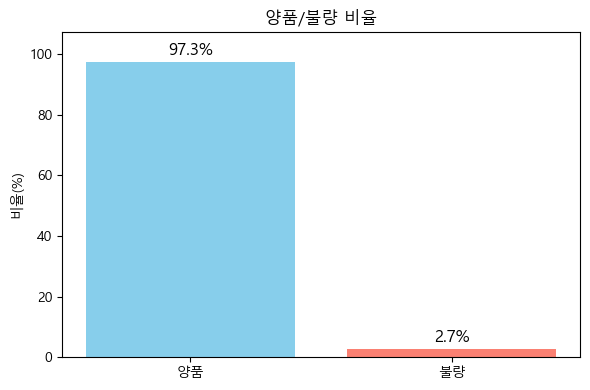

In [183]:
counts = df['judge'].value_counts(normalize=True) * 100
labels = counts.index
values = counts.values

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['skyblue', 'salmon'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('양품/불량 비율')
plt.ylabel('비율(%)')
plt.ylim(0, max(values) + 10)
plt.tight_layout()
plt.show()

### ⓐ 범주형 데이터 시각화

In [184]:
categorical_cols = [col for col in df.select_dtypes(include='object') 
                    if col not in {'charge_id', 'cast_date', 'f_ext_date', 'hr_coil_id', 'hr_date', 'judge', 'ap_date'}]

#### - 히스토그램 시각화

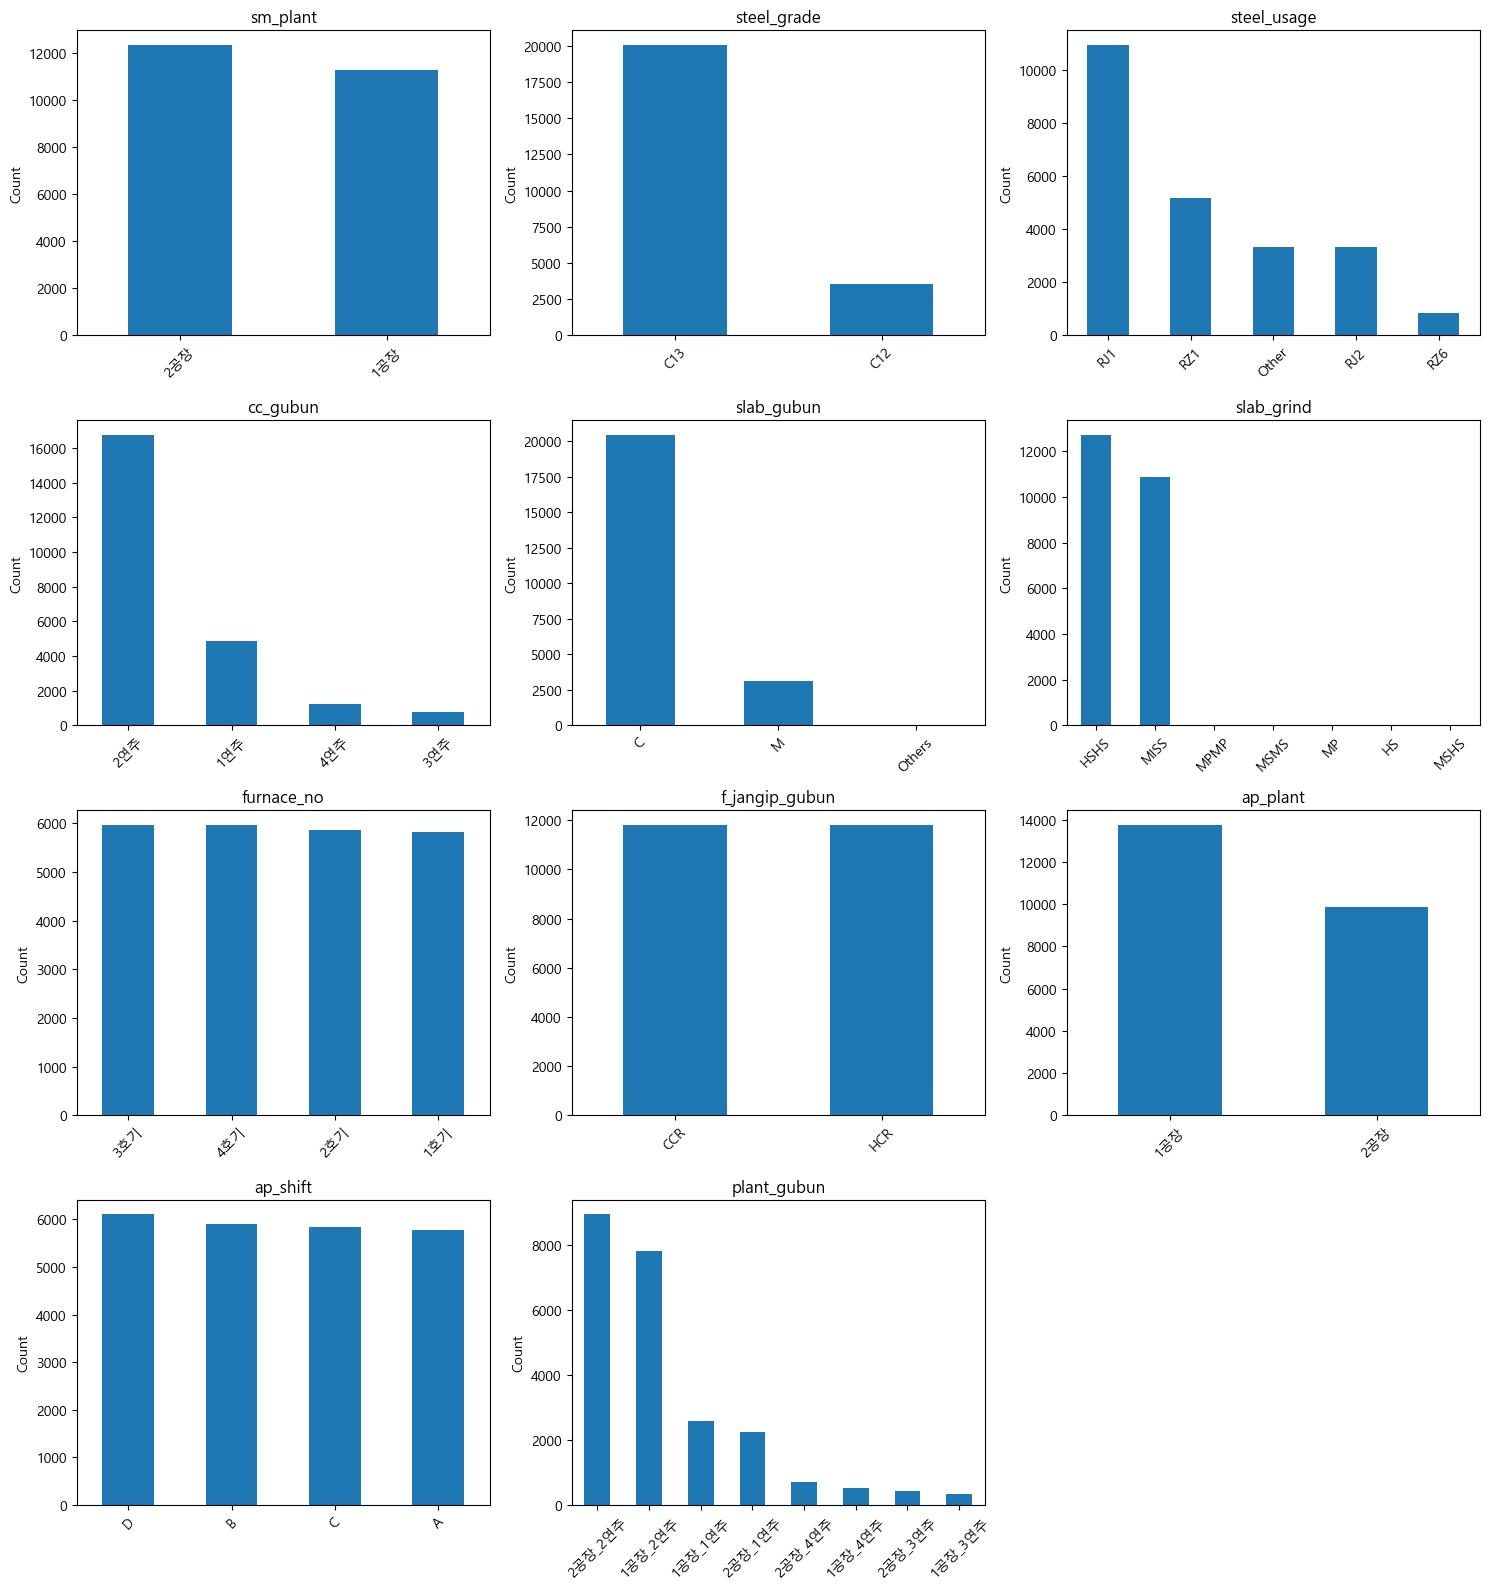

In [185]:
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df[col].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### - 변수별 불량률 시각화

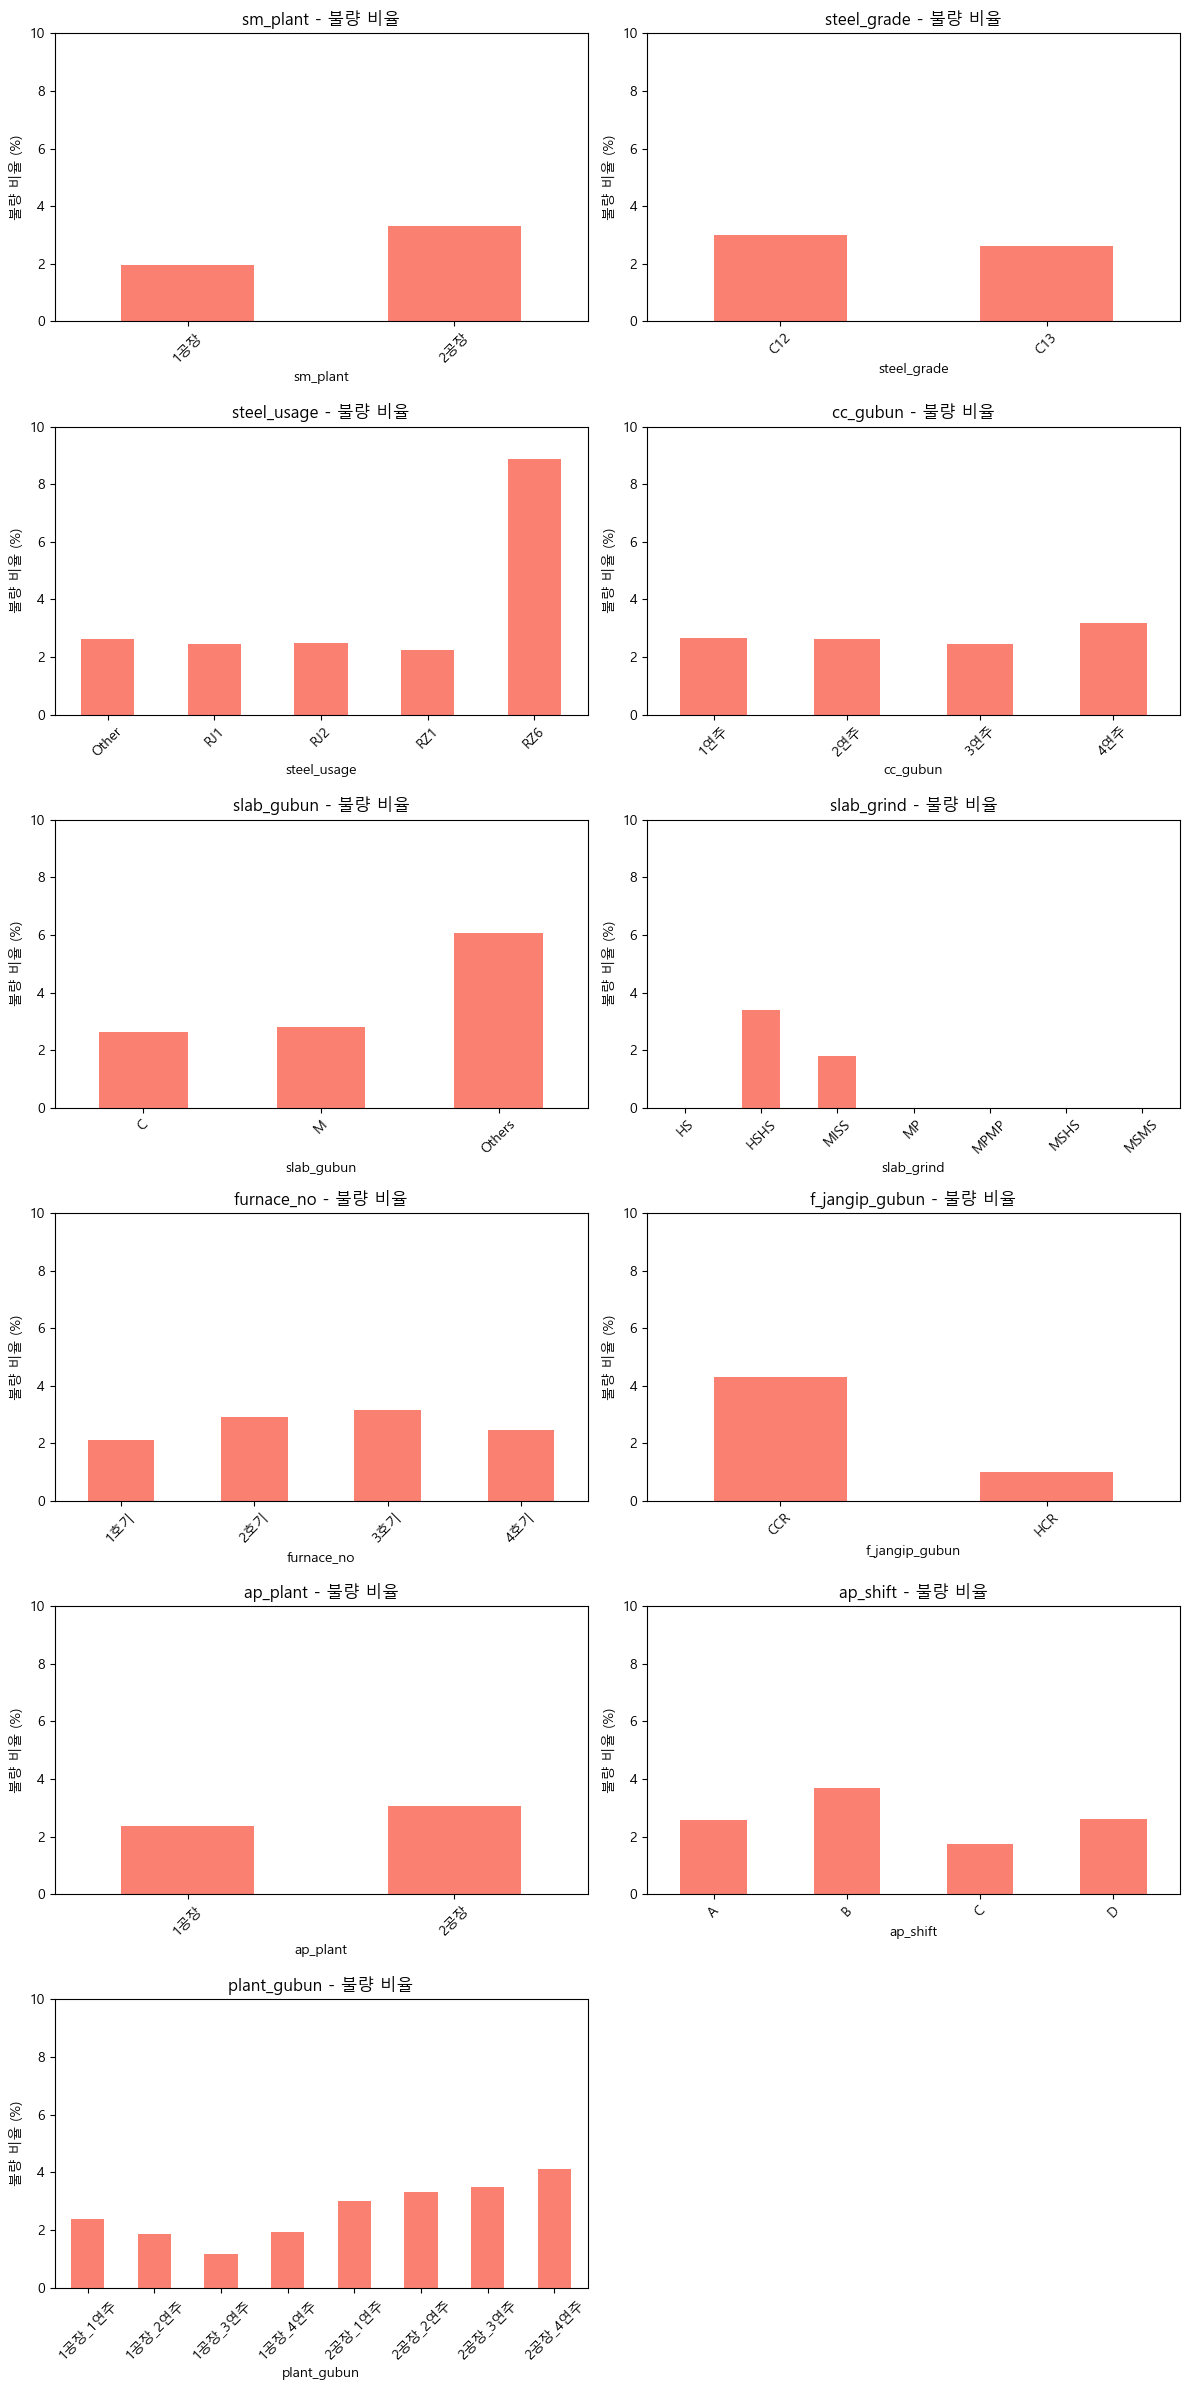

In [186]:
n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    cross = pd.crosstab(df[col], df['judge'], normalize='index') * 100

    if '불량' in cross.columns: 
        defect_rates = cross['불량']
        defect_rates.plot(kind='bar', ax=axes[i], color='salmon')

        axes[i].set_title(f"{col} - 불량 비율")
        axes[i].set_ylabel("불량 비율 (%)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylim(0, 10)
    else:
        axes[i].set_visible(False)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### ⓑ 이산형 데이터 시각화

In [187]:
def plot_boxplots(df, cols):
    n = len(cols)
    rows = (n + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f'{col} Boxplot')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [188]:
def get_outliers_split_iqr(df, cols):
    outlier_summary = {}

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        lower_outliers = df[df[col] < lower_bound]
        upper_outliers = df[df[col] > upper_bound]

        print(f" 변수: {col}")
        print(f" - Q1보다 작은 값 개수: {len(lower_outliers)}")
        print(f" - Q3보다 큰 값 개수: {len(upper_outliers)}")
        print(f" - 총 이상치 개수: {len(lower_outliers) + len(upper_outliers)}\n")

        outlier_summary[col] = {
            'Q1보다 작음': len(lower_outliers),
            'Q3보다 큼': len(upper_outliers),
            '총 이상치': len(lower_outliers) + len(upper_outliers),
            '이상치_데이터프레임': pd.concat([lower_outliers, upper_outliers])
        }

    return outlier_summary

In [189]:
discrete_cols = ['delta_ferrite', 'slab_no', 'f_jangip_temp', 'f_pre_temp', 'f_heat_temp', 'f_sock_temp', 'f_pre_interval',
                'f_heat_interval', 'f_sock_interval', 'f_ext_time', 'hr_width', 'rm4_temp', 'rm_pitch', 'slab_width', 'ap_width']

#### - 박스플롯 시각화

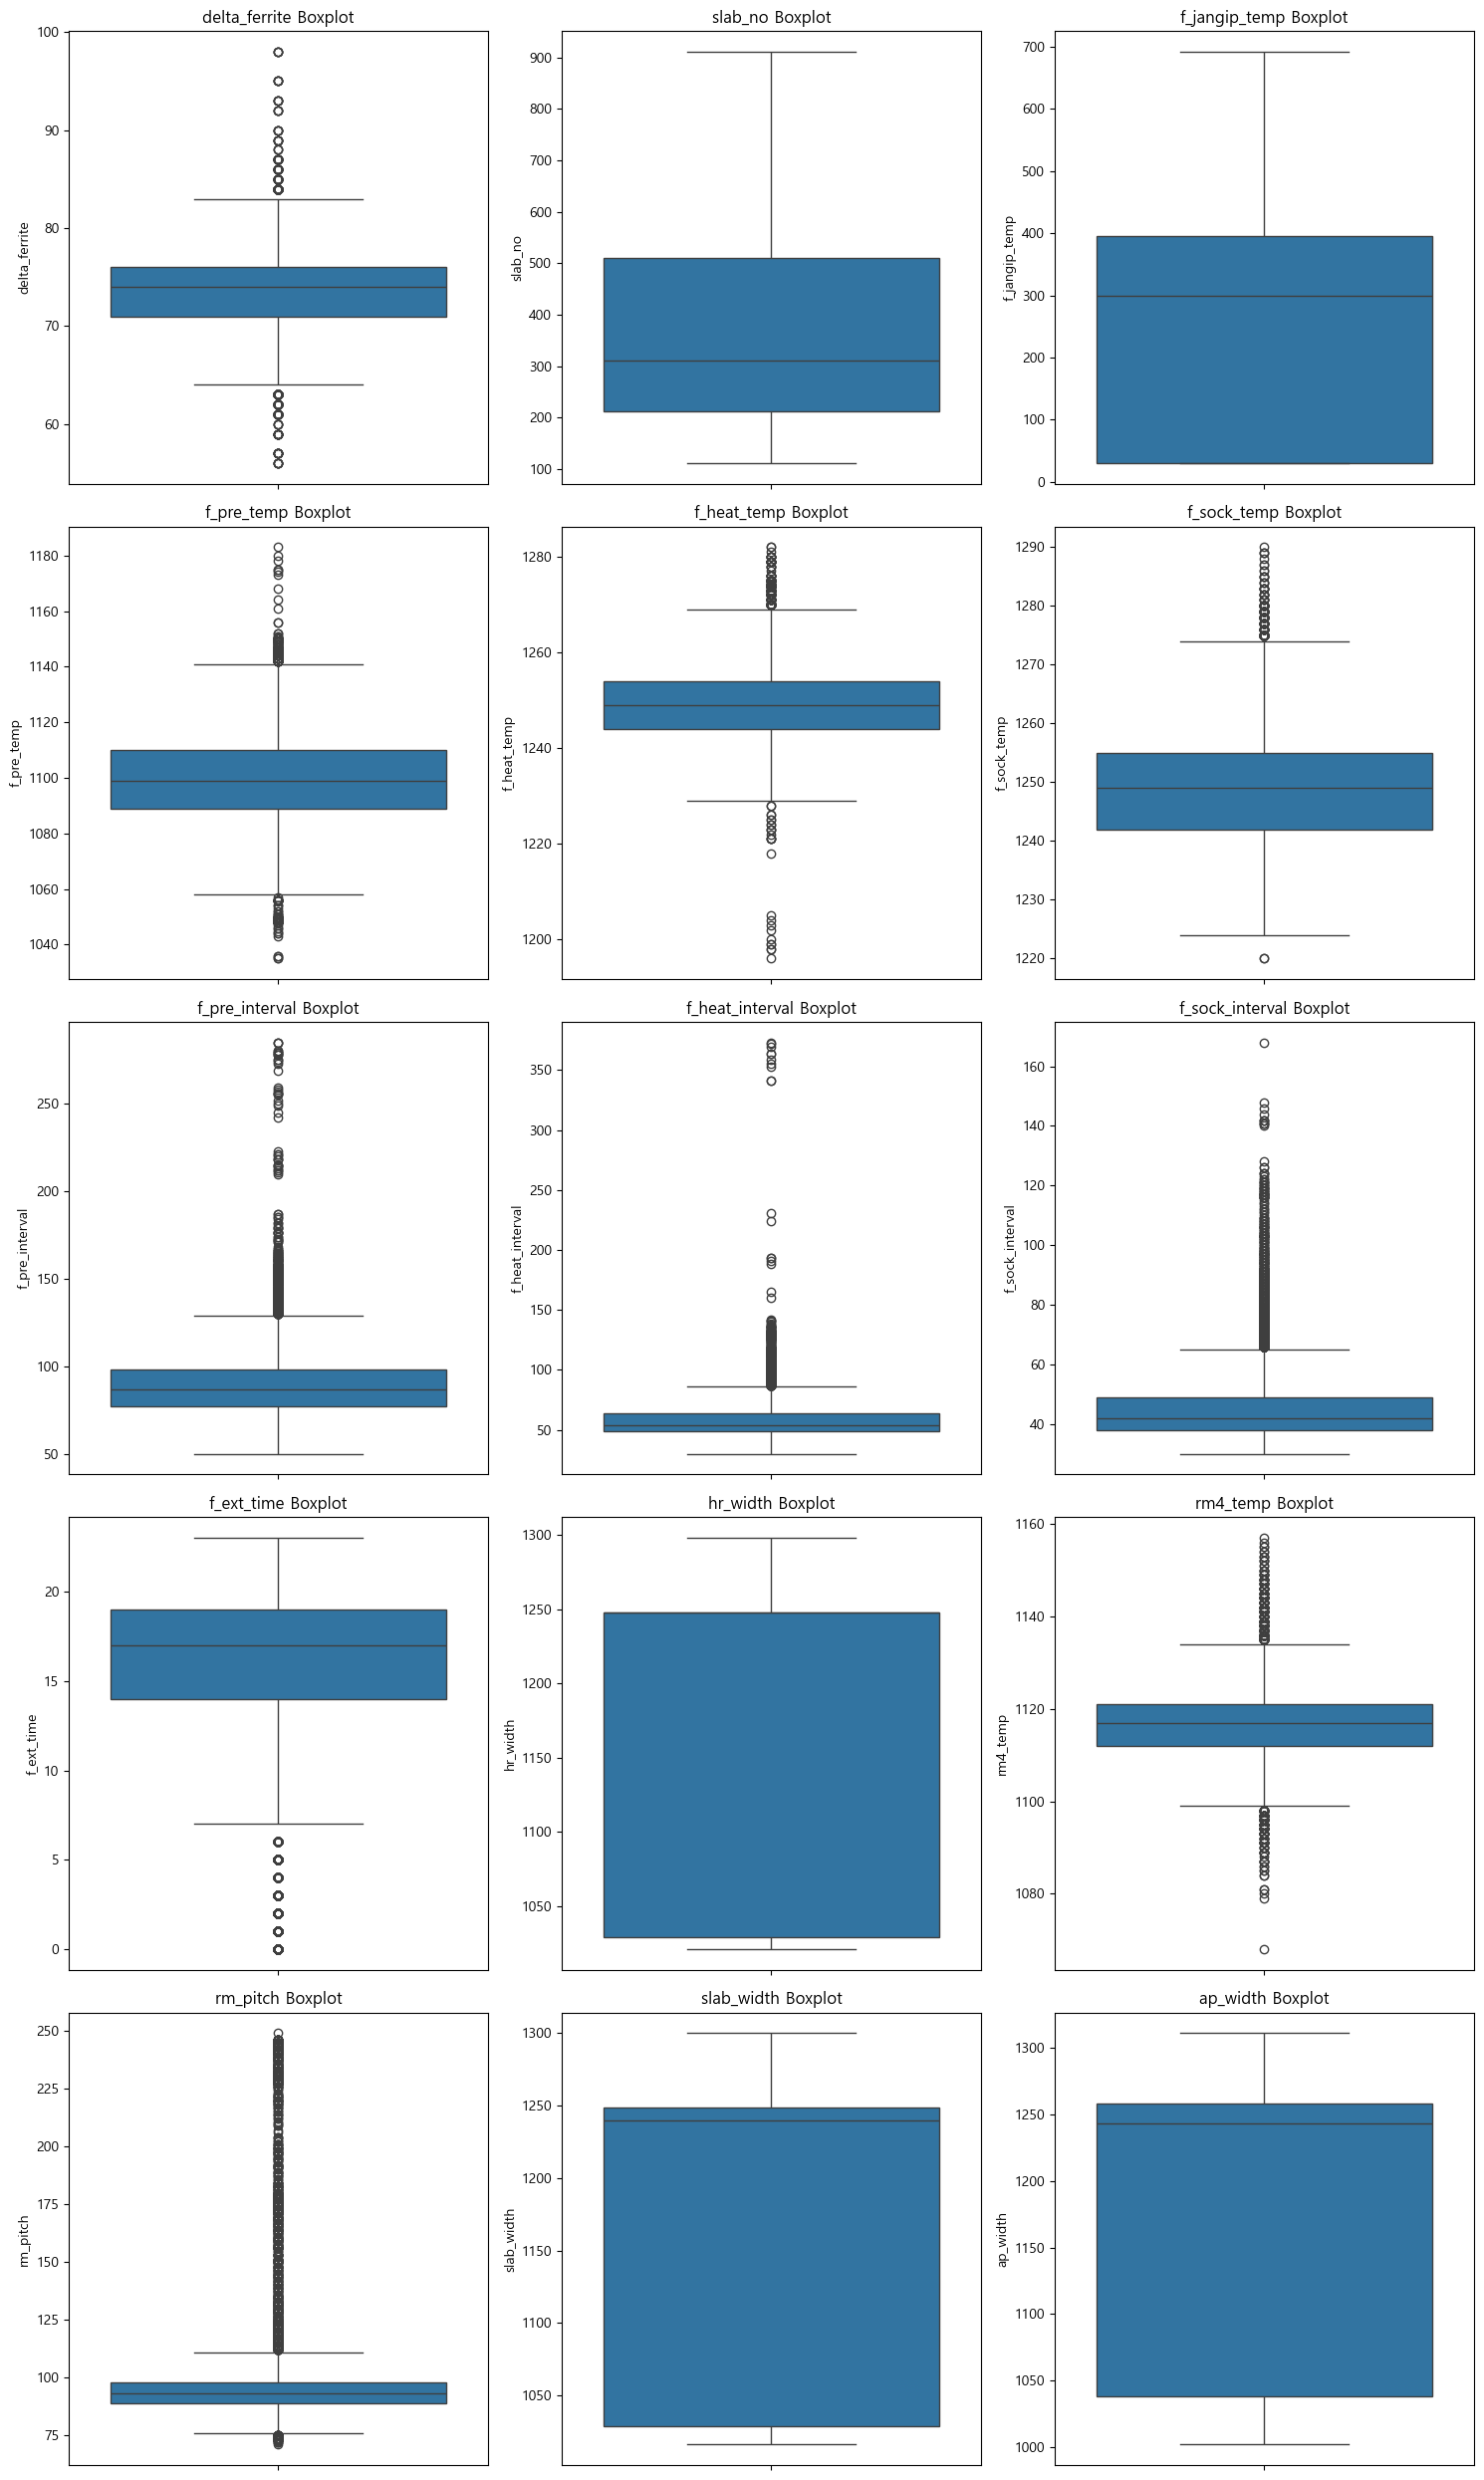

In [190]:
# 박스플롯 시각화
plot_boxplots(df, discrete_cols)

#### - 히스토그램 시각화

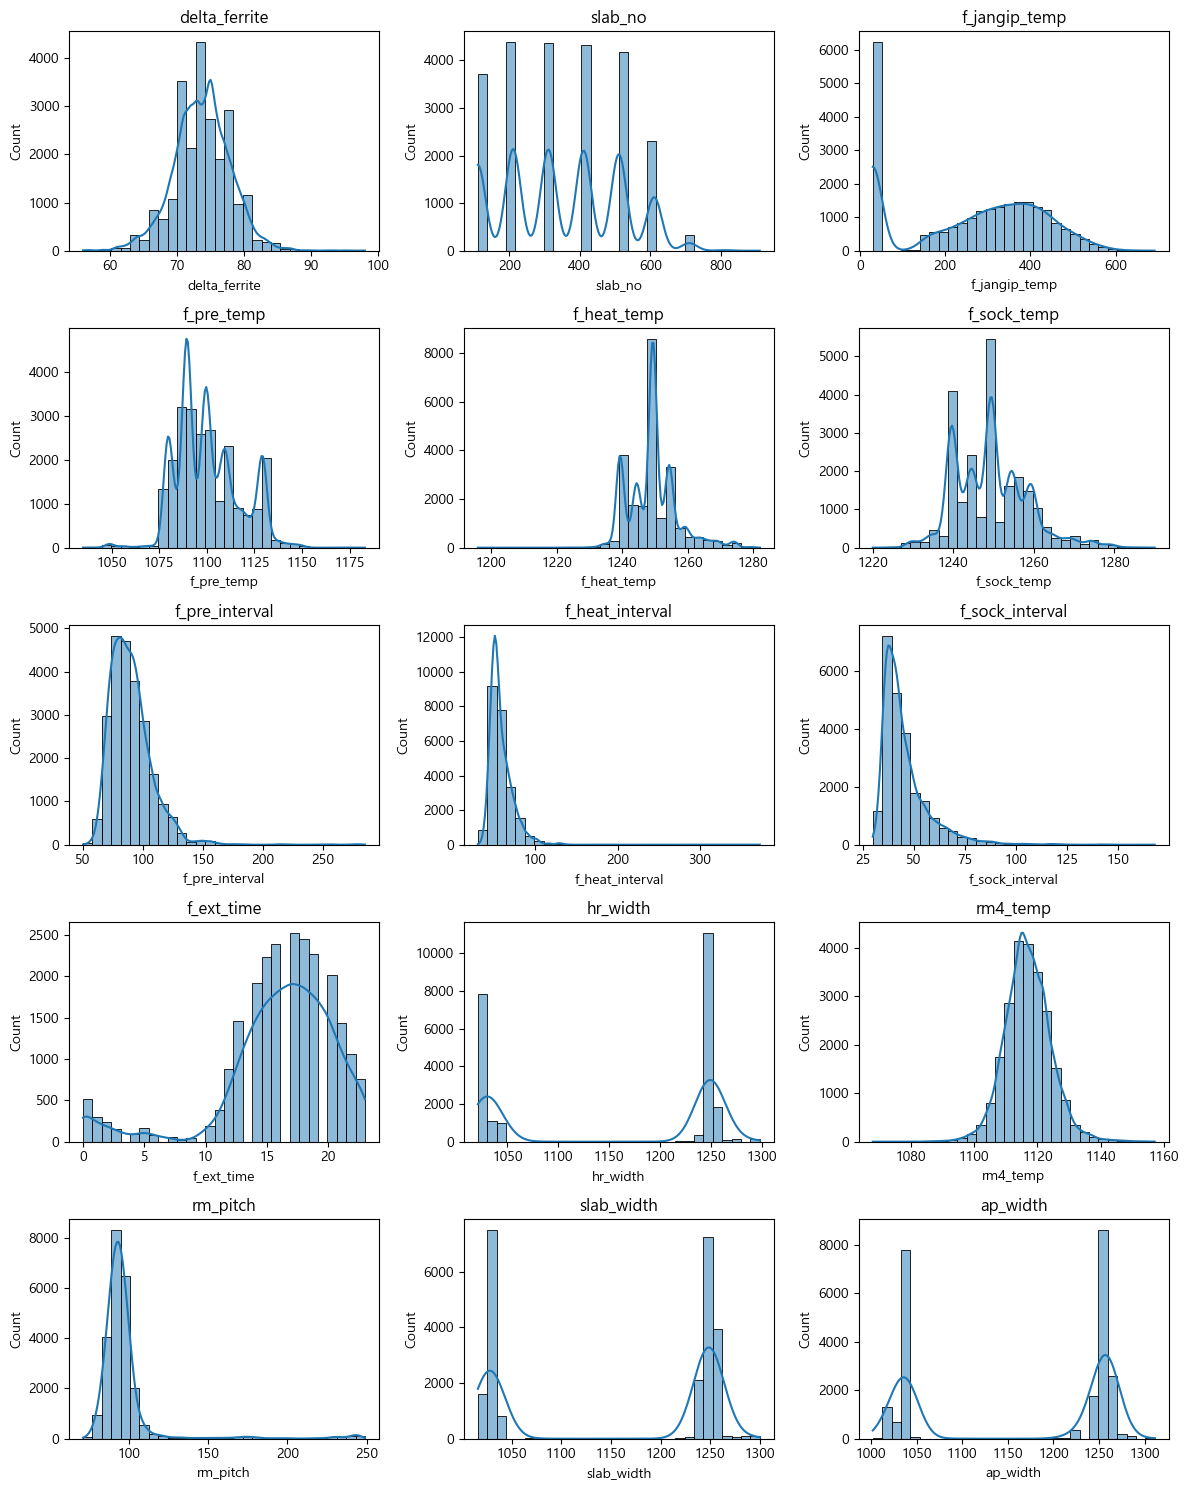

In [191]:
# 히스토그램 시각화
n = len(discrete_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(discrete_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

In [192]:
# discrete_outlier_info = get_outliers_split_iqr(df, discrete_cols)
# discrete_outlier_info

### ⓒ 연속형 데이터 시각화

In [193]:
continuous_cols = [
    'ingre_cr', 'ingre_ni', 'ingre_s', 'tundish_temp',
    'mlac_ratio', 'f_bfg', 'f_cog', 'f_ldg',
    'f_bfg_per', 'f_cog_per', 'f_ldg_per',
    'hr_thick', 'ap_thick', 'ap_line_speed', 'total_time', 'coil_delay_time', 'slab_delay_time','etching_thick' 
]

#### - 박스플롯 시각화

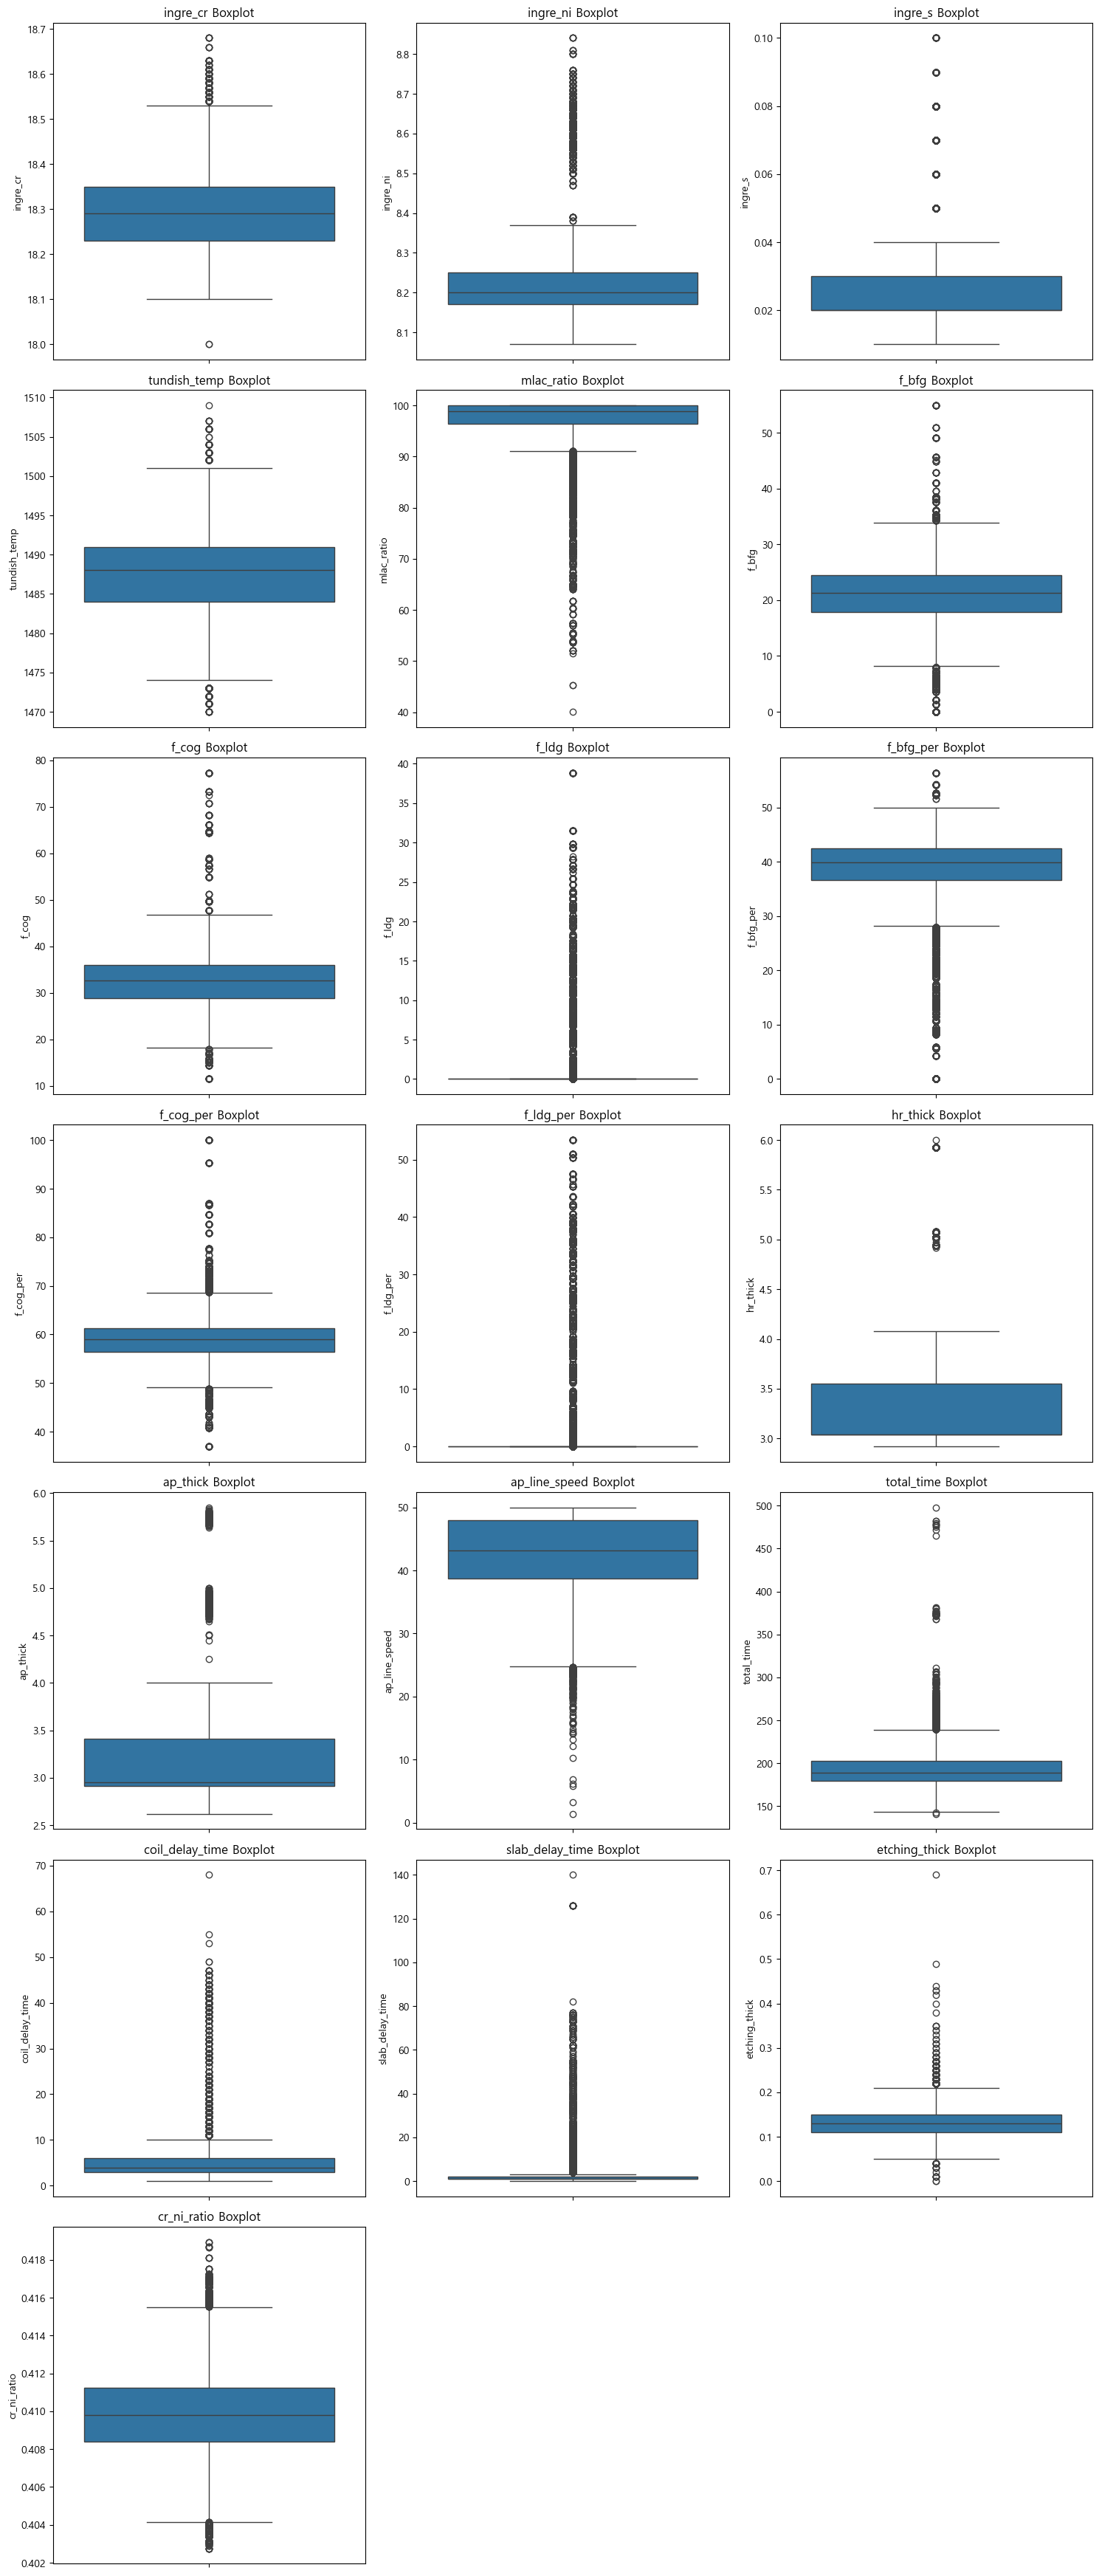

In [194]:
# 박스플롯 시각화
plot_boxplots(df, continuous_cols)

#### - 히스토그램 시각화

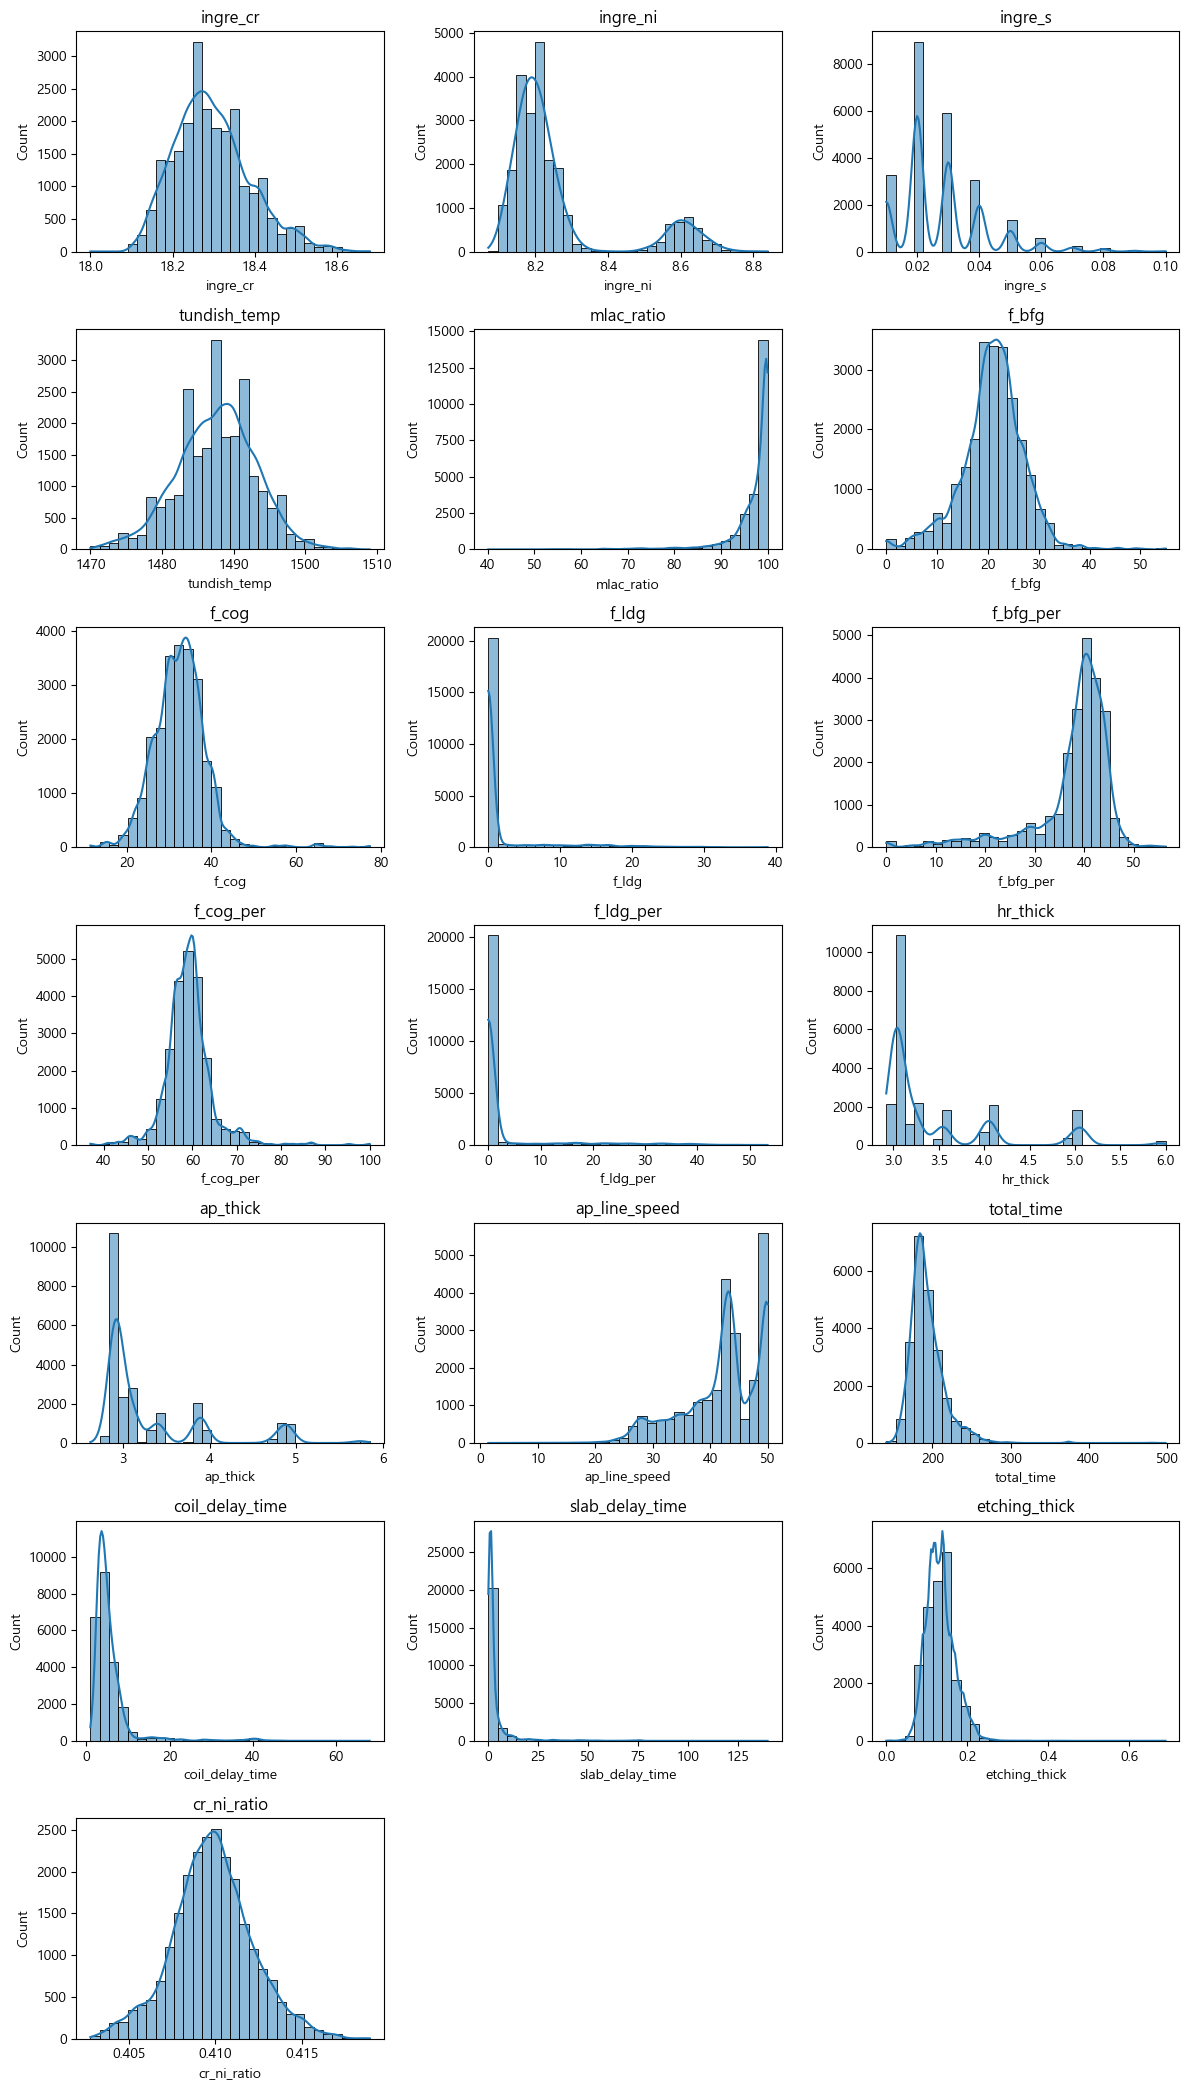

In [195]:
# 히스토그램 시각화
n = len(continuous_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(continuous_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

In [196]:
# continuous_outlier_info = get_discrete_outliers_split_iqr(df, continuous_cols)
# continuous_outlier_info

# 4. EDA
- 연속형 데이터
  - 정규성테스트(`D’Agostino-Pearson`), 등분산성테스트(`Levene Test`) 
  - 정규성, 등분산성 만족 O -> `2 sample t-test`
  - 정규성, 등분산성 만족 X -> `Mann Whiteny U-test`
- 범주형 데이터
  - 기대도수표 5미만인 셀 20% 미만 -> `카이제곱검정`
  - 기대도수표 5미만인 셀 20% 이상 -> `Fisher` (2x2 표일경우), `MonteCarlo`

### ⓐ 연속형 데이터: 통계적 검증

In [197]:
from scipy.stats import normaltest, levene, ttest_ind, mannwhitneyu, shapiro, ranksums

cols = list(df.select_dtypes(include=['int', 'float']).columns)

for col in cols:
    print(f"✅ {col}")
    # 데이터 그룹 나누기
    group_bad = df[df['judge'] == '불량'][col]
    group_good = df[df['judge'] == '양품'][col]
    
    # [1] 정규성 검정 (D’Agostino-Pearson)
    print("[1] 정규성 검정 (D’Agostino-Pearson Test)")
    stat_bad, p_bad = normaltest(group_bad)
    stat_good, p_good = normaltest(group_good)
    print(f"불량 그룹: stat = {stat_bad:.4f}, p = {p_bad:.4f} → {'정규성 만족' if p_bad > 0.05 else '정규성 위배'}")
    print(f"양품 그룹: stat = {stat_good:.4f}, p = {p_good:.4f} → {'정규성 만족' if p_good > 0.05 else '정규성 위배'}")
    
    # [2] 등분산성 검정 (Levene Test)
    print("\n[2] 등분산성 검정 (Levene Test)")
    levene_result = levene(group_bad, group_good)
    equal_var = levene_result.pvalue > 0.05
    print(f"Levene stat = {levene_result.statistic:.4f}, p = {levene_result.pvalue:.4f} → {'등분산성 있음' if equal_var else '등분산성 없음'} (equal_var={equal_var})")
    
    # [3] 평균 차이 검정 (t-test)
    print("\n[3] 평균 차이 검정 (t-test)")
    ttest_result = ttest_ind(group_bad, group_good, equal_var=equal_var)
    print(f"t = {ttest_result.statistic:.4f}, p = {ttest_result.pvalue:.4f} → {'유의한 차이 있음' if ttest_result.pvalue < 0.05 else '차이 없음'}")
    
    # [4] 비모수 검정 (Mann-Whitney U Test)
    print("\n[4] 비모수 검정 (Mann-Whitney U Test)")
    mw_stat, mw_p = mannwhitneyu(group_bad, group_good, alternative='two-sided')
    print(f"Mann-Whitney U = {mw_stat:.4f}, p = {mw_p:.4f} → {'중앙값 차이 유의함' if mw_p < 0.05 else '차이 없음'}")

    # [5] 비모수 검정 (Wilcoxon Rank-Sum Test)
    print("\n[5] 비모수 검정 (Wilcoxon Rank-Sum Test)")
    rs_stat, rs_p = ranksums(group_bad, group_good)
    print(f"Rank-Sum z = {rs_stat:.4f}, p = {rs_p:.4f} → {'중앙값 차이 유의함' if rs_p < 0.05 else '차이 없음'}")
    
    print('\n\n')

✅ delta_ferrite
[1] 정규성 검정 (D’Agostino-Pearson Test)
불량 그룹: stat = 127.6544, p = 0.0000 → 정규성 위배
양품 그룹: stat = 311.1413, p = 0.0000 → 정규성 위배

[2] 등분산성 검정 (Levene Test)
Levene stat = 23.3072, p = 0.0000 → 등분산성 없음 (equal_var=False)

[3] 평균 차이 검정 (t-test)
t = -0.0170, p = 0.9864 → 차이 없음

[4] 비모수 검정 (Mann-Whitney U Test)
Mann-Whitney U = 6892467.5000, p = 0.0427 → 중앙값 차이 유의함

[5] 비모수 검정 (Wilcoxon Rank-Sum Test)
Rank-Sum z = -2.0205, p = 0.0433 → 중앙값 차이 유의함



✅ ingre_cr
[1] 정규성 검정 (D’Agostino-Pearson Test)
불량 그룹: stat = 56.1695, p = 0.0000 → 정규성 위배
양품 그룹: stat = 1179.6786, p = 0.0000 → 정규성 위배

[2] 등분산성 검정 (Levene Test)
Levene stat = 7.9784, p = 0.0047 → 등분산성 없음 (equal_var=False)

[3] 평균 차이 검정 (t-test)
t = -2.0860, p = 0.0374 → 유의한 차이 있음

[4] 비모수 검정 (Mann-Whitney U Test)
Mann-Whitney U = 6956490.0000, p = 0.1006 → 차이 없음

[5] 비모수 검정 (Wilcoxon Rank-Sum Test)
Rank-Sum z = -1.6412, p = 0.1008 → 차이 없음



✅ ingre_ni
[1] 정규성 검정 (D’Agostino-Pearson Test)
불량 그룹: stat = 157.1266, p = 0.0000 → 정규성 위배


### ⓑ 범주형 데이터: 통계적 검증

In [198]:
def monte_carlo_chi2_test(df, category_col, target_col, n_simulations=10000, seed=42):
    """
    Monte Carlo 방식의 카이제곱 독립성 검정
    - df: DataFrame
    - category_col: 범주형 설명 변수 (예: 'slab_grind')
    - target_col: 이항 목표 변수 (예: 'judge')
    - n_simulations: 시뮬레이션 횟수
    """
    np.random.seed(seed)
    
    # 분할표 생성
    table = pd.crosstab(df[category_col], df[target_col])
    observed = table.to_numpy()

    # 실제 카이제곱 통계량 계산
    chi2_actual, _, _, _ = chi2_contingency(observed, correction=False)

    # 시뮬레이션
    total = observed.sum()
    shape = observed.shape
    greater_count = 0

    for _ in range(n_simulations):
        simulated = np.random.multinomial(total, [1 / (shape[0] * shape[1])] * (shape[0] * shape[1]))
        simulated = simulated.reshape(shape)

        try:
            chi2_sim, _, _, _ = chi2_contingency(simulated, correction=False)
            if chi2_sim >= chi2_actual:
                greater_count += 1
        except:
            continue

    # Monte Carlo p-value 계산
    p_value = greater_count / n_simulations

    return {
        'chi2_statistic': chi2_actual,
        'monte_carlo_p_value': p_value,
        'contingency_table': table
    }

In [199]:
from scipy.stats import chi2_contingency, fisher_exact, permutation_test

cols = list(df.select_dtypes(include=['object']).columns)

for col in cols:
    print(f"💠 {col}")
    # 데이터 그룹 나누기
    # col와 judge 간 교차표 만들기
    contingency = pd.crosstab(df[col], df['judge'])
    
    print(f" [1] 교차표 ({col} vs judge):")
    print(contingency)
    
    # 카이제곱 검정 실행
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print("\n [2] 기대빈도 (Expected Frequencies):")
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    print(expected_df)
    
    # 기대빈도 조건 확인
    low_expected = (expected < 5).sum()
    total_cells = expected.size
    low_ratio = low_expected / total_cells
    
    print(f"\n 기대빈도 5 미만 셀 비율: {low_ratio:.2%}")
    if low_ratio > 0.2 or (expected < 1).any():
        print(" 기대빈도 조건 위반 → Fisher 정확 검정 또는 범주 통합 필요")
        # 2x2 교차표일 경우만 Fisher’s Exact Test 사용 가능
        if contingency.shape == (2, 2):
            print("\n [3] Fisher의 정확 검정:")
            oddsratio, p_fisher = fisher_exact(contingency)
            print(f"p-value (Fisher) = {p_fisher:.4f}\n")
            
        print(" 기대빈도 조건 위반시 -> 몬테카를로 결과")
        result = monte_carlo_chi2_test(df, category_col=col, target_col='judge')
        print("Contingency Table:")
        print(result['contingency_table'])
        print(f"\nChi² 통계량: {result['chi2_statistic']:.4f}")
        print(f"Monte Carlo 기반 p-value: {result['monte_carlo_p_value']:.4f}")
    else:        
        print("\n [3] 카이제곱 독립성 검정 결과:")
        print(f"Chi2 = {chi2:.4f}, p = {p:.4f}")
        if p < 0.05:
            print(f" 유의미한 관련성 있음 → {col}은 불량률과 관련 있음")
        else:
            print(f" 통계적으로 관련 없음 → {col}은 불량률에 영향 없음")
        
    print('\n\n')

💠 sm_plant
 [1] 교차표 (sm_plant vs judge):
judge      불량     양품
sm_plant            
1공장       220  11059
2공장       409  11941

 [2] 기대빈도 (Expected Frequencies):
judge            불량           양품
sm_plant                        
1공장       300.24508  10978.75492
2공장       328.75492  12021.24508

 기대빈도 5 미만 셀 비율: 0.00%

 [3] 카이제곱 독립성 검정 결과:
Chi2 = 41.6320, p = 0.0000
 유의미한 관련성 있음 → sm_plant은 불량률과 관련 있음



💠 charge_id
 [1] 교차표 (charge_id vs judge):
judge      불량  양품
charge_id        
CH42126     0   2
CH42157     0   1
CH42171     0   1
CH42193     0   1
CH42207     0   1
...        ..  ..
CH87497     0   1
CH87508     0   5
CH87509     0   5
CH87510     0   3
CH87516     0   1

[5631 rows x 2 columns]

 [2] 기대빈도 (Expected Frequencies):
judge            불량        양품
charge_id                    
CH42126    0.053240  1.946760
CH42157    0.026620  0.973380
CH42171    0.026620  0.973380
CH42193    0.026620  0.973380
CH42207    0.026620  0.973380
...             ...       ...
CH87497    0.026620

### ⓒ 히트맵

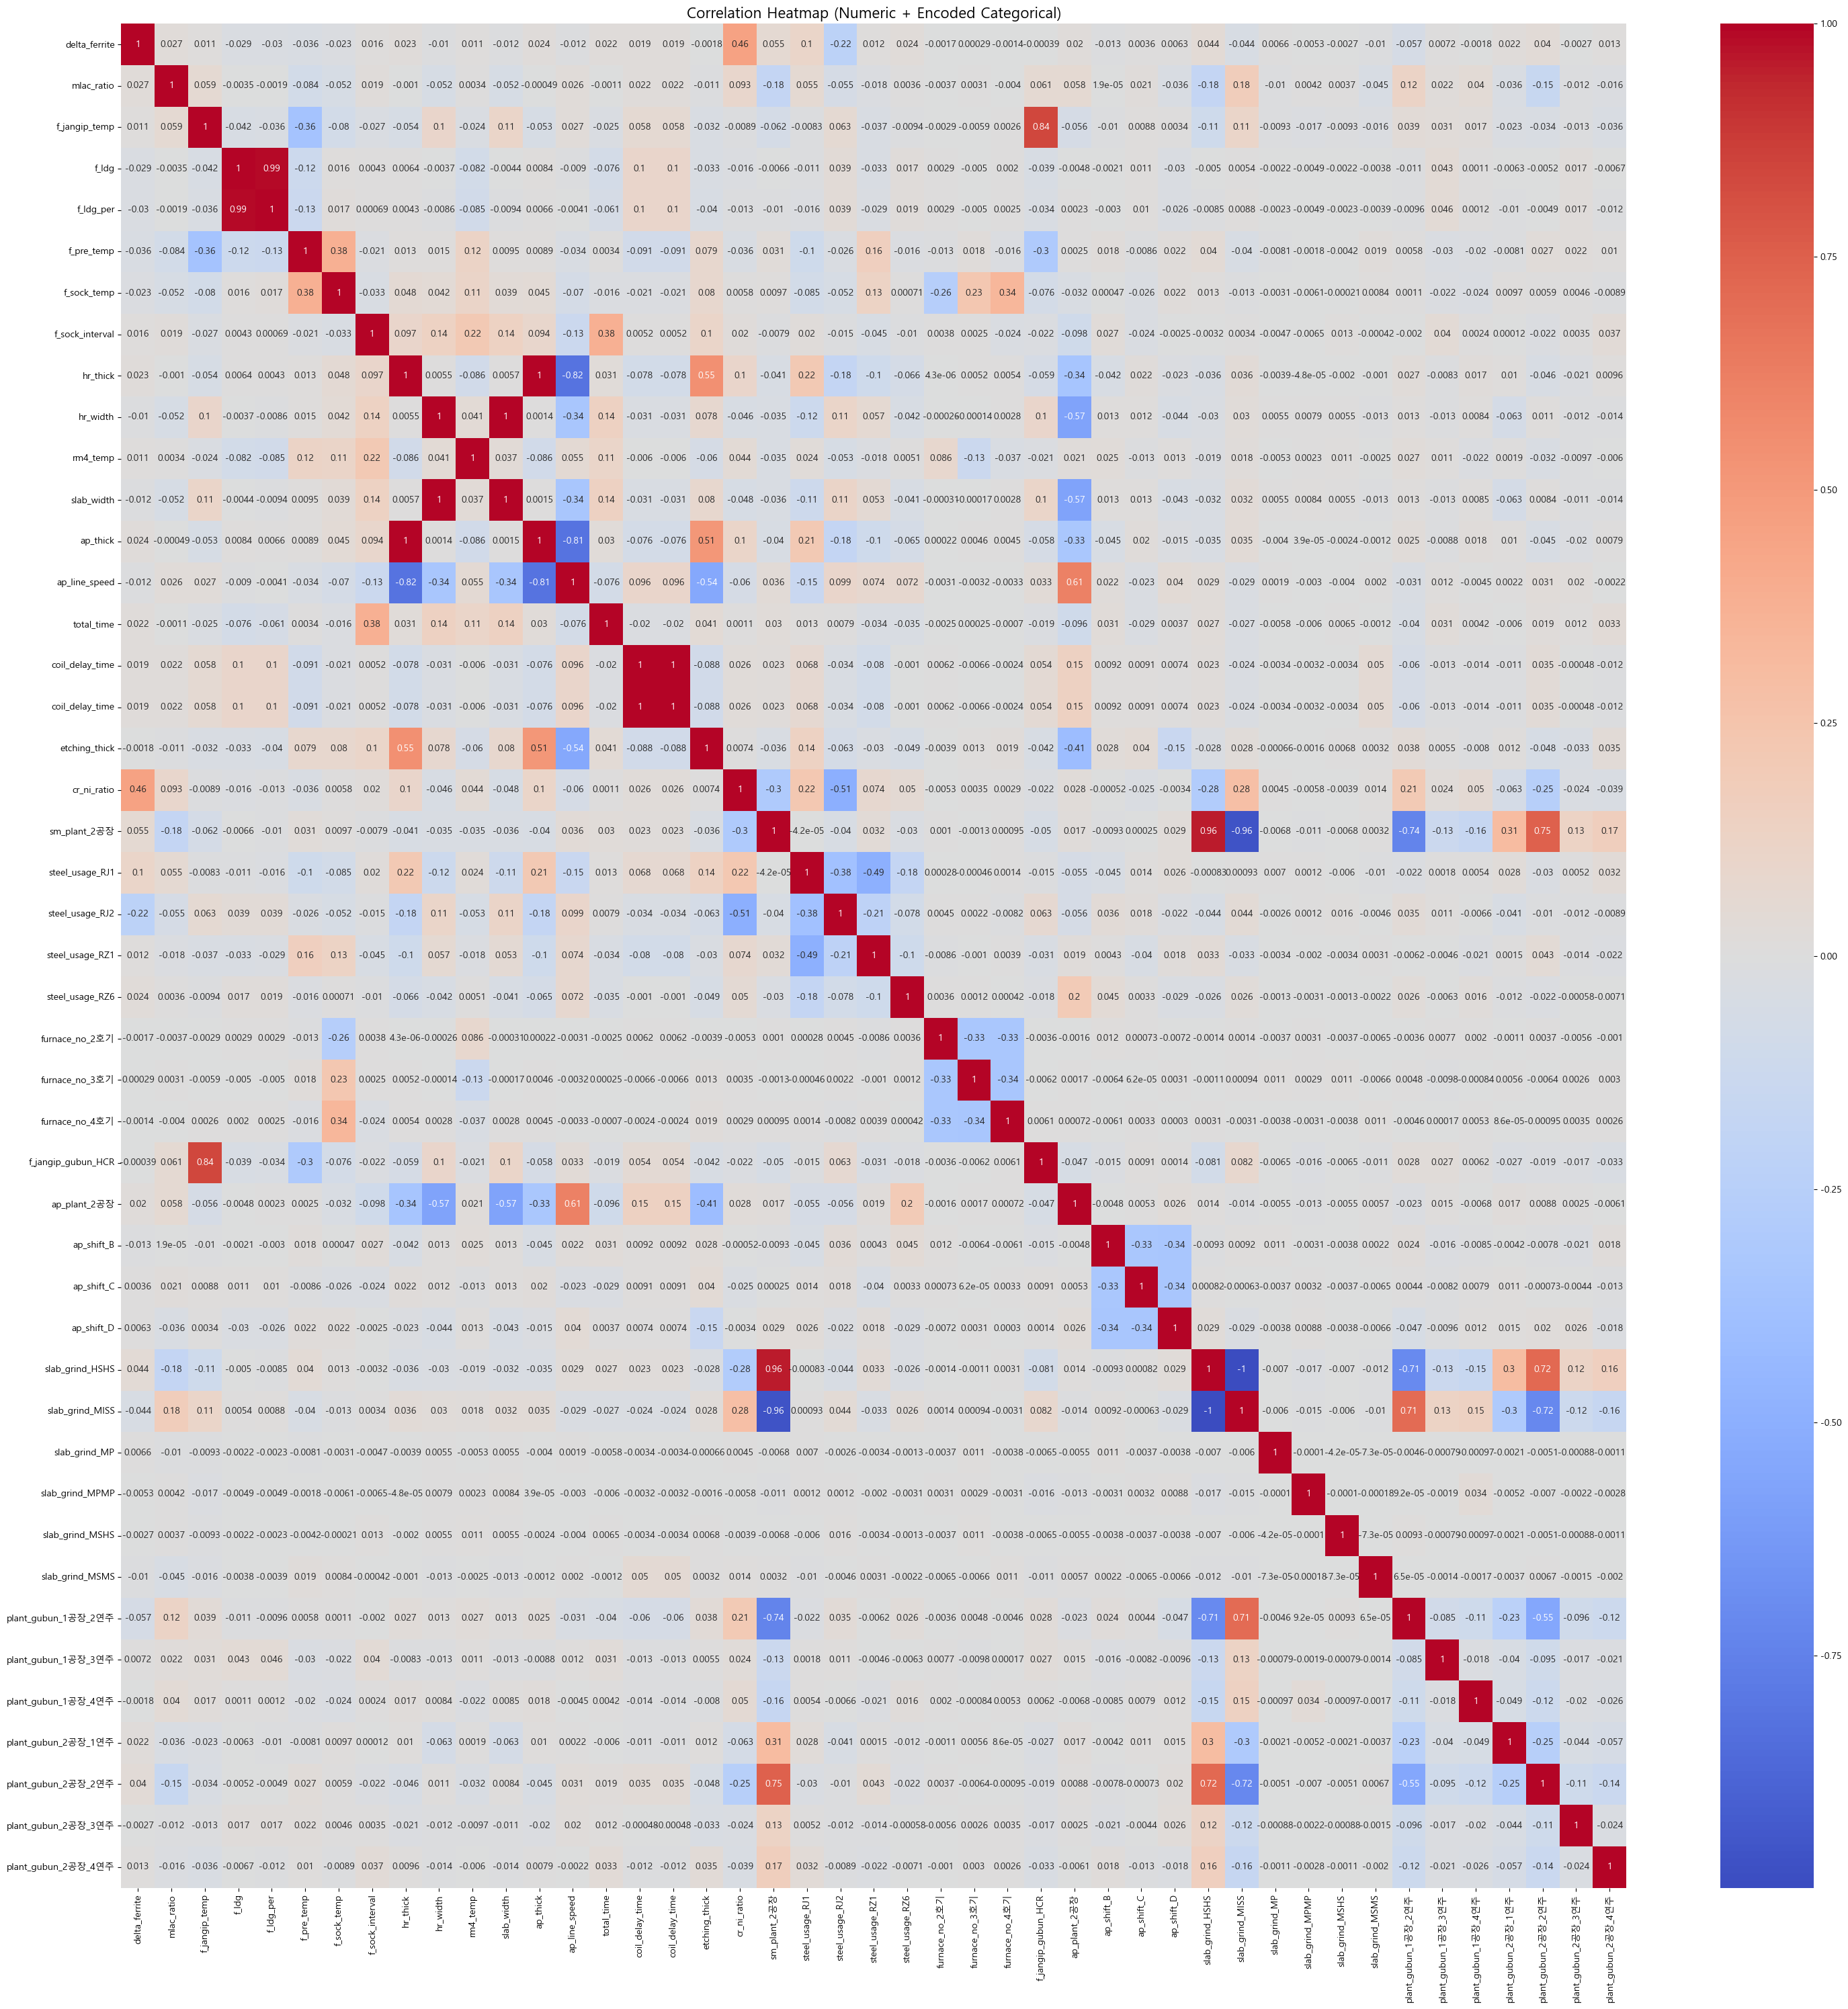

In [201]:
categorical_cols = [
    'sm_plant', 'steel_usage', 'furnace_no', 'f_jangip_gubun',
    'ap_plant', 'ap_shift', 'slab_grind', 'plant_gubun'
]

numeric_cols = [
    'delta_ferrite', 'mlac_ratio', 'f_jangip_temp', 'f_ldg', 'f_ldg_per',
    'f_pre_temp', 'f_sock_temp', 'f_sock_interval', 'hr_thick', 'hr_width',
    'rm4_temp', 'slab_width', 'ap_thick', 'ap_line_speed',
    'total_time', 'coil_delay_time', 'coil_delay_time', 'etching_thick', 'cr_ni_ratio'
]

df_encoded_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)
df_for_heatmap = pd.concat([df[numeric_cols], df_encoded_categorical], axis=1)

plt.figure(figsize=(30, 30))
sns.heatmap(df_for_heatmap.corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap (Numeric + Encoded Categorical)", fontsize=16)
plt.tight_layout()
plt.show()

### ⓓ VIF(다중공선성) 확인

In [ ]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.api import add_constant

# def calculate_vif(df):
#     df_encoded = pd.get_dummies(df, drop_first=True)
#     # df_encoded = add_constant(df_encoded)

#     vif_data = pd.DataFrame({
#         'Variable': df_encoded.columns,
#         'VIF': [variance_inflation_factor(df_encoded.values, i) for i in range(df_encoded.shape[1])]
#     })

#     return vif_data.sort_values(by="VIF", ascending=False)

### ⓔ plant_gubun별, 월별 원인 파악

In [724]:
## 모든 열 보기 옵션
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', None)

new_df = df.groupby('plant_gubun').mean(numeric_only=True)
new_df.loc[['1공장_3연주', '2공장_4연주']]

,delta_ferrite,ingre_cr,ingre_ni,ingre_s,tundish_temp,mlac_ratio,slab_no,f_jangip_temp,f_bfg,f_cog,f_ldg,f_bfg_per,f_cog_per,f_ldg_per,f_pre_temp,f_heat_temp,f_sock_temp,f_pre_interval,f_heat_interval,f_sock_interval,f_ext_time,hr_thick,hr_width,rm4_temp,rm_pitch,slab_width,ap_thick,ap_width,ap_line_speed,total_time,coil_delay_time,slab_delay_time,etching_thick
plant_gubun,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1공장_3연주,7.398547,18.315116,8.254942,0.035000,1487.343023,98.021221,342.395349,305.773256,18.643898,31.183895,3.566081,34.988077,58.536774,6.475148,1096.56686,1247.709302,1247.680233,92.427326,57.406977,49.255814,15.851744,3.393721,1146.377907,1117.572674,95.790698,1144.909884,3.258605,1152.465116,42.871686,199.090116,5.168605,1.680233,0.135116
2공장_4연주,7.403960,18.277737,8.268331,0.023154,1487.210750,96.648798,357.958982,230.957567,20.792003,32.757703,1.552791,37.834863,59.665986,2.499151,1101.64215,1248.579915,1248.835926,90.684583,59.056577,47.854314,15.564356,3.474682,1149.096181,1116.688826,97.014144,1147.319661,3.334158,1155.323904,42.102744,197.595474,5.346535,6.985856,0.140523


In [727]:
new_df2 = df.groupby(by=['plant_gubun', 'f_jangip_gubun']).mean(numeric_only=True)
new_df2.loc[['1공장_3연주', '2공장_4연주']]

delta_ferrite   ingre_cr  ingre_ni   ingre_s  \
plant_gubun f_jangip_gubun                                                 
1공장_3연주     CCR                  7.332090  18.319627  8.256642  0.035373   
            HCR                  7.440952  18.312238  8.253857  0.034762   
2공장_4연주     CCR                  7.391429  18.279595  8.266214  0.023167   
            HCR                  7.422300  18.275017  8.271429  0.023136   

                            tundish_temp  mlac_ratio     slab_no  \
plant_gubun f_jangip_gubun                                         
1공장_3연주     CCR              1486.783582   97.088806  370.701493   
            HCR              1487.700000   98.616190  324.333333   
2공장_4연주     CCR              1487.792857   97.050238  369.095238   
            HCR              1486.358885   96.061324  341.662021   

                            f_jangip_temp      f_bfg      f_cog     f_ldg  \
plant_gubun f_jangip_gubun                                                  
1공장_3연주     CCR                134.253731  18.256187  29.650552  3.319784   
            HCR                415.219048  18.891295  32.162314  3.723243   
2공장_4연주     CCR                124.195238  20.642262  32.322407  2.414581   
            HCR                387.195122  21.011136  33.394721  0.291634   

                            f_bfg_per  f_cog_per  f_ldg_per   f_pre_temp  \
plant_gubun f_jangip_gubun                                                 
1공장_3연주     CCR             34.986027  57.652666   7.361307  1099.388060   
            HCR             34.989386  59.100919   5.909695  1094.766667   
2공장_4연주     CCR             37.614198  58.556518   3.829283  1105.816667   
            HCR             38.157788  61.289597   0.552615  1095.533101   

                            f_heat_temp  f_sock_temp  f_pre_interval  \
plant_gubun f_jangip_gubun                                             
1공장_3연주     CCR             1248.067164  1249.097015       98.119403   
            HCR             1247.480952  1246.776190       88.795238   
2공장_4연주     CCR             1249.485714  1249.552381       91.619048   
            HCR             1247.254355  1247.787456       89.317073   

                            f_heat_interval  f_sock_interval  f_ext_time  \
plant_gubun f_jangip_gubun                                                 
1공장_3연주     CCR                   55.171642        44.141791   16.194030   
            HCR                   58.833333        52.519048   15.633333   
2공장_4연주     CCR                   58.035714        47.450000   15.790476   
            HCR                   60.550523        48.445993   15.233449   

                            hr_thick     hr_width     rm4_temp   rm_pitch  \
plant_gubun f_jangip_gubun                                                  
1공장_3연주     CCR             3.449254  1105.305970  1116.753731  96.201493   
            HCR             3.358286  1172.585714  1118.095238  95.528571   
2공장_4연주     CCR             3.389857  1129.569048  1117.085714  96.776190   
            HCR             3.598815  1177.672474  1116.108014  97.362369   

                             slab_width  ap_thick     ap_width  ap_line_speed  \
plant_gubun f_jangip_gubun                                                      
1공장_3연주     CCR             1103.037313  3.312015  1112.014925      42.376119   
            HCR             1171.628571  3.224524  1178.276190      43.187905   
2공장_4연주     CCR             1127.154762  3.248095  1135.907143      43.018286   
            HCR             1176.829268  3.460105  1183.738676      40.762927   

                            total_time  coil_delay_time  slab_delay_time  \
plant_gubun f_jangip_gubun                                                 
1공장_3연주     CCR             197.432836         5.373134         3.171642   
            HCR             200.147619         5.038095         0.728571   
2공장_4연주     CCR             197.104762         5.633333        11.092857   
            HCR       

In [731]:
df.groupby('cast_month').mean(numeric_only=True)

,delta_ferrite,ingre_cr,ingre_ni,ingre_s,tundish_temp,mlac_ratio,slab_no,f_jangip_temp,f_bfg,f_cog,f_ldg,f_bfg_per,f_cog_per,f_ldg_per,f_pre_temp,f_heat_temp,f_sock_temp,f_pre_interval,f_heat_interval,f_sock_interval,f_ext_time,hr_thick,hr_width,rm4_temp,rm_pitch,slab_width,ap_thick,ap_width,ap_line_speed,total_time,coil_delay_time,slab_delay_time,etching_thick
cast_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02,6.900000,18.290000,8.220000,0.020000,1489.000000,100.000000,611.000000,30.000000,21.668000,30.227000,0.000000,41.753541,58.246459,0.000000,1084.000000,1244.000000,1248.000000,87.000000,56.000000,49.000000,19.000000,5.020000,1278.000000,1117.000000,103.000000,1278.000000,4.850000,1288.000000,28.200000,192.000000,7.000000,140.000000,0.170000
2024-04,7.371429,18.325714,8.304286,0.062857,1489.714286,94.942857,453.857143,30.000000,20.743857,29.427571,0.000000,41.316589,58.683411,0.000000,1104.000000,1242.571429,1243.857143,83.000000,53.000000,44.000000,20.571429,3.014286,1102.428571,1112.142857,103.714286,1094.714286,2.898571,1113.000000,48.500000,180.000000,25.000000,111.857143,0.115714
2024-05,7.095556,18.272667,8.216889,0.028889,1488.288889,96.346667,351.000000,30.000000,20.135133,30.486289,0.000000,39.738461,60.261539,0.000000,1099.977778,1249.733333,1248.088889,99.711111,54.044444,49.577778,15.688889,3.599111,1221.844444,1117.222222,100.311111,1219.933333,3.463778,1227.800000,40.142444,203.333333,9.244444,62.911111,0.135333
2024-06,7.362809,18.302533,8.268279,0.027847,1487.797927,98.371100,361.662061,240.236615,19.842314,32.961822,0.614172,36.847718,62.229935,0.922347,1095.953944,1246.435233,1246.318365,88.253310,58.296488,45.432355,16.233161,3.446908,1163.044329,1117.550374,97.464018,1161.938975,3.310984,1166.834197,42.285941,191.982153,6.026482,11.322395,0.135924
2024-07,7.419786,18.303351,8.269718,0.028715,1487.272629,96.760565,352.932420,285.859140,21.651144,33.266242,0.337474,39.074049,60.342091,0.583860,1098.748134,1247.411318,1246.313340,88.975166,58.233546,45.613380,15.657213,3.407165,1158.280907,1117.884109,98.347537,1156.877053,3.273276,1162.990365,42.437620,192.822093,4.807708,3.288642,0.133889
2024-08,7.360110,18.288684,8.250191,0.027582,1487.640066,97.075521,349.353458,251.802964,22.194369,32.755479,1.593542,39.002933,58.191109,2.805958,1107.521076,1251.285401,1252.362459,90.097914,57.589901,45.039297,16.164984,3.448089,1150.507025,1116.792316,96.216246,1148.498793,3.311488,1155.926674,42.254636,192.727113,6.485730,2.338529,0.136600
2024-09,7.339776,18.298468,8.256662,0.025881,1487.756903,97.253955,343.630597,266.447948,18.157056,30.935687,4.337737,34.088899,58.148727,7.762374,1093.242724,1249.100373,1249.136381,90.767537,58.758396,45.818470,16.324627,3.462160,1167.733955,1115.697201,97.483769,1166.179478,3.335043,1171.994030,41.706306,195.344403,5.446455,2.074440,0.127118


In [734]:
df.groupby(by=['ap_month', 'steel_usage']).count()

sm_plant  charge_id  steel_grade  delta_ferrite  \
ap_month steel_usage                                                    
2024-07  Other            1160       1160         1160           1160   
         RJ1              4093       4093         4093           4093   
         RJ2              1102       1102         1102           1102   
         RZ1               302        302          302            302   
         RZ6               237        237          237            237   
2024-08  Other            1094       1094         1094           1094   
         RJ1              3176       3176         3176           3176   
         RJ2              1129       1129         1129           1129   
         RZ1              3244       3244         3244           3244   
         RZ6               340        340          340            340   
2024-09  Other            1077       1077         1077           1077   
         RJ1              3685       3685         3685           3685   
         RJ2              1091       1091         1091           1091   
         RZ1              1631       1631         1631           1631   
         RZ6               268        268          268            268   

                      ingre_cr  ingre_ni  ingre_s  cast_date  cc_gubun  \
ap_month steel_usage                                                     
2024-07  Other            1160      1160     1160       1160      1160   
         RJ1              4093      4093     4093       4093      4093   
         RJ2              1102      1102     1102       1102      1102   
         RZ1               302       302      302        302       302   
         RZ6               237       237      237        237       237   
2024-08  Other            1094      1094     1094       1094      1094   
         RJ1              3176      3176     3176       3176      3176   
         RJ2              1129      1129     1129       1129      1129   
         RZ1              3244      3244     3244       3244      3244   
         RZ6               340       340      340        340       340   
2024-09  Other            1077      1077     1077       1077      1077   
         RJ1              3685      3685     3685       3685      3685   
         RJ2              1091      1091     1091       1091      1091   
         RZ1              1631      1631     1631       1631      1631   
         RZ6               268       268      268        268       268   

                      tundish_temp  mlac_ratio  slab_no  slab_gubun  \
ap_month steel_usage                                                  
2024-07  Other                1160        1160     1160        1160   
         RJ1                  4093        4093     4093        4093   
         RJ2                  1102        1102     1102        1102   
         RZ1                   302         302      302         302   
         RZ6                   237         237      237         237   
2024-08  Other                1094        1094     1094        1094   
         RJ1                  3176        3176     3176        3176   
         RJ2                  1129        1129     1129        1129   
         RZ1                  3244        3244     3244        3244   
         RZ6                   340         340      340         340   
2024-09  Other                1077        1077     1077        1077   
         RJ1                  3685        3685     3685        3685   
         RJ2                  1091        1091     1091        1091   
         RZ1                  1631        1631     1631        1631   
         RZ6                   268         268      268         268   

                      slab_grind  furnace_no  f_jangip_gubun  f_jangip_temp  \
ap_month steel_usage                                                          
2024-07  Other              1160        1160            1160           1160   
         RJ1                4093        4093            4093           4093 

### ⓕ 변수별 최적조건 탐색

In [ ]:
# pip install tabulate

In [317]:
# # 자세히 확인
# cols = df.select_dtypes(include=['int', 'float'])
# for col in cols:
#     sns.kdeplot(data=df, x=col, hue='judge', fill=True)
#     plt.ylim((0, 0.005))
#     plt.show()

In [207]:
# for col in cols:
#     sns.violinplot(data=df, x='judge', y=col, inner='box')
#     plt.show()

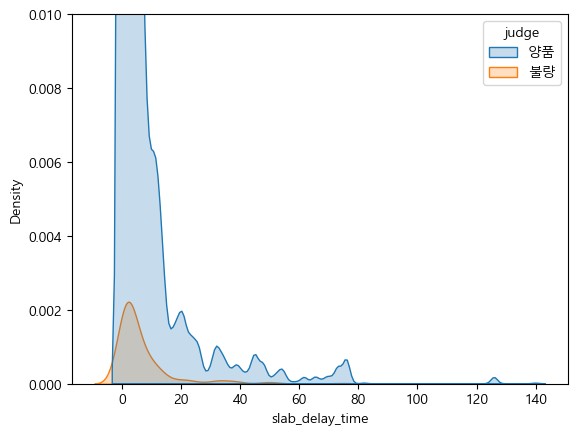

In [812]:
col = 'slab_delay_time'
sns.kdeplot(data=df, x=col, hue='judge', fill=True)
plt.ylim(0, 0.010)
plt.show()
# plt.figure(figsize=(10, 6))

# data_min = df[col].min()
# data_max = df[col].max()
# bins = np.linspace(data_min, data_max, 30)

# good = df[df['judge'] == '양품'][col]
# bad = df[df['judge'] == '불량'][col]

# good_hist, _ = np.histogram(good, bins=bins)
# bad_hist, _ = np.histogram(bad, bins=bins)

# good_ratio = good_hist / good.sum()
# bad_ratio = bad_hist / bad.sum()

# bin_centers = 0.5 * (bins[1:] + bins[:-1])
# bin_width = bins[1] - bins[0]

# plt.plot(bin_centers, good_ratio, color='blue', marker='o', linestyle='-', label='양품 (line)')
# plt.plot(bin_centers, bad_ratio, color='red', marker='o', linestyle='-', label='불량 (line)')

# tick_interval = (data_max - data_min) / 30 
# xticks = np.arange(data_min, data_max + tick_interval, tick_interval)
# plt.xticks(xticks, rotation=90) 

# plt.xlabel(f'{col}')
# plt.ylabel('비율 (해당 구간 수 / 전체 수)')
# plt.title(f'{col} Histogram by Judge (Ratio)')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [136]:
# cols = [col]
# for col in cols:
#     # 설명변수의 bin 경계 설정
#     bins = np.linspace(df[col].min(), df[col].max(), num=30)
    
#     # 각 bin에 대한 양품, 불량, 전체 개수 계산
#     df['bin'] = pd.cut(df[col], bins=bins, include_lowest=True)
    
#     # bin별 통계 계산
#     bin_counts = df.groupby('bin')['judge'].value_counts().unstack(fill_value=0)
#     bin_total_counts = df.groupby('bin').size()
    
#     # 비율 계산
#     bin_counts['구간_내_양품_비율'] = bin_counts['양품'] / bin_total_counts
#     bin_counts['구간_내_불량_비율'] = bin_counts['불량'] / bin_total_counts
    
#     fig, ax1 = plt.subplots(figsize=(10, 5))
    
#     # 불량 갯수 그래프
#     ax1.bar(bin_counts.index.astype(str), bin_counts['불량'], label='불량 갯수', align='center', color='skyblue', alpha=0.7)
#     ax1.set_xlabel(f'{col} Bins')
#     ax1.set_ylabel('불량품 갯수', color='blue')
#     ax1.tick_params(axis='y', labelcolor='blue')
#     ax1.set_title(f'{col} 구간별 불량 갯수')
#     ax1.set_xticks(range(len(bin_counts.index)))
#     ax1.set_xticklabels([str(interval) for interval in bin_counts.index], rotation=45, ha='right')
    
#     # 불량 비율 그래프
#     ax2 = ax1.twinx()
#     # ax2.bar(bin_counts.index.astype(str), bin_counts['불량'], label='불량 비율', align='center', color='red', alpha=0.7)
#     ax2.plot(range(len(bin_counts.index)), bin_counts['구간_내_불량_비율'],label='불량 비율 (line)', color='darkred', marker='o', linestyle='-')
#     ax2.set_ylabel('불량 비율 (불량 개수 / 구간별 전체 개수)', color='red')
#     ax2.tick_params(axis='y', labelcolor='red')
    
#     lines, labels = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc='upper left')

#     ax2.set_ylim(0, 0.2)

#     plt.tight_layout()
#     plt.show()
    
#     total_data_count = len(df)
#     bin_counts['불량률_전체기준'] = bin_counts['불량'] / total_data_count
#     bin_counts['누적_불량률'] = bin_counts['불량'].cumsum() / total_data_count
    
#     from tabulate import tabulate
    
#     print_table = bin_counts[['양품', '불량', '구간_내_양품_비율', '구간_내_불량_비율', '불량률_전체기준', '누적_불량률']].copy()
#     print_table[['구간_내_양품_비율', '구간_내_불량_비율', '불량률_전체기준', '누적_불량률']] *= 100
    
#     print("\n구간별 양품/불량 및 비율 (%):")
#     table = tabulate(
#         print_table,
#         headers='keys',
#         tablefmt='pretty',
#         floatfmt=".3f%%",
#         showindex=True
#     )
#     print(table)

### ⓖ 불량률 계산공식

In [819]:
col = 'slab_delay_time'
a = 1 
b = 0
filtered_df = df[df['judge']=='불량']
bad_count = len(filtered_df[(filtered_df[col] < a)])
total_count = len(df)

defect_rate = bad_count / total_count * 100
print("불량률:", defect_rate)
print(bad_count)

불량률: 0.06771340302171061
16


# 5. 모델링

In [90]:
pip install imbalanced-learn

In [169]:
# 샘플링 라이브러리
from imblearn.over_sampling import ADASYN, RandomOverSampler, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split

# 하이퍼파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 모델 라이브러리
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, precision_recall_curve

### 모델링 전 전처리
- 불량품 클러스터링
- 불량품 오버샘플링
  - SMOTETomek 
  - Borderline SMOTE
  - ADASYN 
- GridSearchCV

In [162]:
# 클러스터링 전 코드
# # 설명변수 선택
# selected_columns = ["delta_ferrite", "f_jangip_temp", "f_pre_temp",
#                     "f_sock_temp", "f_sock_interval", "ap_line_speed", "slab_delay_time",
#                     "coil_delay_time", "rm4_temp", "mlac_ratio"]

# # 설명변수, 목표변수 분리
# df_raw_x = df.drop("judge", axis = 1, inplace = False)
# df_raw_x = df_raw_x[selected_columns]
# df_raw_x = pd.get_dummies(df_raw_x)

# df_raw_y = df["judge"].map(lambda x: 1 if x=='불량' else 0)

# # 데이터 샘플링
# ## - 원본 데이터 분리
# x_train, x_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size=0.3, stratify=df_raw_y, random_state=1234)

# ## - 불량품 오버샘플링을 위한 원본 데이터 분리
# # bad_x_train, _, bad_y_train, _ = train_test_split(bad_filtered_x, bad_filtered_y, test_size=0.3, stratify=bad_filtered_y, random_state=42)

# ## 소수 클래스만 오버샘플링
# ros = RandomOverSampler(sampling_strategy={1: 16100}, random_state=42)
# x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

# ## - 오버샘플링(BorderlineSMOTE)1 데이터 분리
# smote = BorderlineSMOTE(random_state=42)
# x_train_smote, y_ㅊ  train_smote = smote.fit_resample(x_train, y_train)

# ## - 오버샘플링(ADASYN)2 데이터 분리
# adasyn = ADASYN(random_state=42)
# x_train_ad, y_train_ad = adasyn.fit_resample(x_train, y_train)

# ## - 오버샘플링(SMOTEENN)3 데이터 분리
# smote_enn = SMOTEENN(random_state=42)
# x_train_senn, y_train_senn = smote_enn.fit_resample(x_train, y_train)

# ## - 언더샘플링
# rus = RandomUnderSampler(random_state=42)
# x_train_under, y_train_under = rus.fit_resample(x_train, y_train)

# ## 샘플링 결과 확인
# from collections import Counter

# print("원본 y_train 분포:", Counter(y_train))
# print("Ros y_train 분포:", Counter(y_train_ros))
# print("BorderlineSMOTE y_train 분포:", Counter(y_train_smote))
# print("ADASYN y_train 분포:", Counter(y_train_ad))
# print("SMOTEENN y_train 분포:", Counter(y_train_senn))
# print("UnderSampling y_train 분포:", Counter(y_train_under))

In [290]:
selected_columns = ['delta_ferrite',
       'ingre_cr', 'ingre_ni', 'ingre_s',
       'tundish_temp', 'mlac_ratio', 'f_jangip_temp', 
       'f_ldg', 'f_pre_temp','f_jangip_gubun', 'sm_plant',
       'f_heat_temp', 'f_sock_temp', 'f_pre_interval', 
       'f_sock_interval',
       'hr_thick', 'hr_width', 'rm4_temp','ap_line_speed']

# 범주형, 수치형 각각 나눠서 더미화
categorical_cols = ['f_jangip_gubun', 'sm_plant']
numeric_selected = [col for col in selected_columns if col not in categorical_cols]

df_features = df.drop(columns=['judge'])
df_dummy_features = pd.get_dummies(df_features, columns=categorical_cols)
df_dummy = pd.concat([df_dummy_features, df['judge']], axis=1)
dummy_columns = [col for col in df_dummy.columns if any(c in col for c in categorical_cols)]
final_selected_columns = numeric_selected + dummy_columns

# 클러스터링
df_defect = df_dummy[df_dummy["judge"] == "불량"]
df_defect_x = df_defect[final_selected_columns]

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(df_defect_x)
df_defect["cluster"] = clusters

df_cluster_sampled = df_defect.groupby("cluster").sample(frac=1.0, random_state=42)

# 
df_good = df_dummy[df_dummy["judge"] == "양품"]
df_sampled = pd.concat([df_good, df_cluster_sampled])

X = df_sampled[final_selected_columns]
y = df_sampled["judge"].map(lambda x: 1 if x == "불량" else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [291]:
# 오버샘플링 (훈련 데이터에만 적용!)
smote = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

smote2 = BorderlineSMOTE(random_state=42)
X_train_res2, y_train_res2 = smote2.fit_resample(X_train, y_train)

adasyn = ADASYN(random_state=42)
X_train_res3, y_train_res3 = adasyn.fit_resample(X_train, y_train)

## BalancedRandomForestClassifier

#### - smoteTomek 샘플링 활용

In [128]:
param_grid = {
    'n_estimators': [40, 50, 100, 150],
    'max_depth': [5, 10, 15, 20, 30, 40, 50], 
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

clf = BalancedRandomForestClassifier(random_state=42)
grid_tree = RandomizedSearchCV(clf, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1)
grid_tree.fit(X_train_res, y_train_res)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 50}
best score :  0.9900413814537293


In [152]:
clf = BalancedRandomForestClassifier(
    n_estimators=50,
    min_samples_split=2,
    min_samples_leaf=3,
    max_depth=50,
    class_weight='balanced', 
    random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4600
           1       0.35      0.46      0.40       126

    accuracy                           0.96      4726
   macro avg       0.67      0.72      0.69      4726
weighted avg       0.97      0.96      0.97      4726



#### - ✅ BorderlineSMOTE 샘플링 활용

In [143]:
param_grid = {
    'n_estimators': [40, 50, 100, 150],
    'max_depth': [5, 10, 15, 20, 30, 40, 50], 
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

clf = BalancedRandomForestClassifier(random_state=42)
grid_tree = RandomizedSearchCV(clf, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1)
grid_tree.fit(X_train_res2, y_train_res2)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 30}
best score :  0.9901124713241003


In [163]:
clf = BalancedRandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=30,
    class_weight='balanced', 
    random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] 

threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4600
           1       0.52      0.35      0.42       126

    accuracy                           0.97      4726
   macro avg       0.75      0.67      0.70      4726
weighted avg       0.97      0.97      0.97      4726



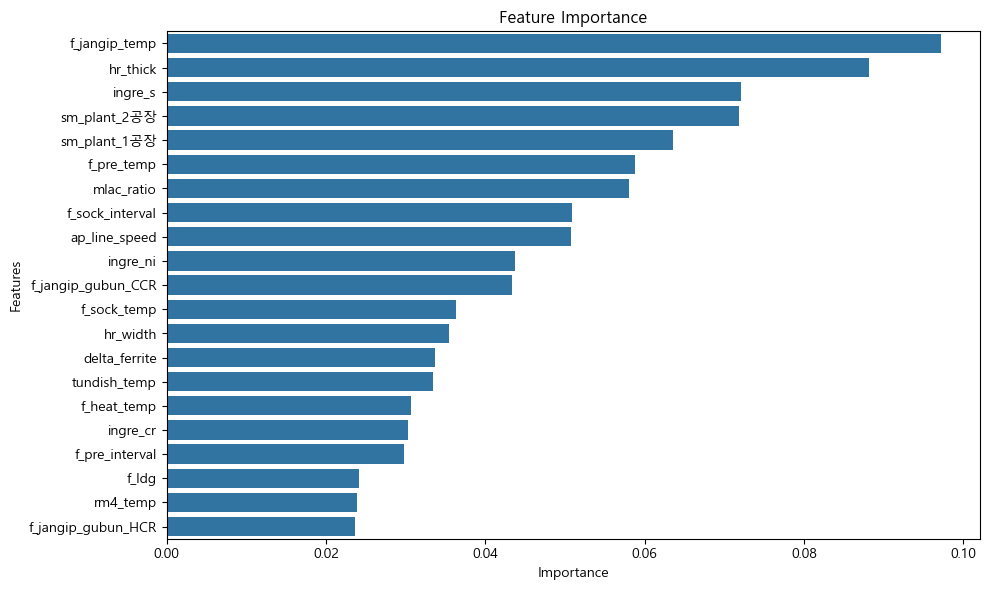

In [165]:
importance = pd.Series(clf.feature_importances_, index=X_train_res.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### - ADASYN 샘플링 활용

In [154]:
param_grid = {
    'n_estimators': [40, 50, 100, 150],
    'max_depth': [5, 10, 15, 20, 30, 40, 50], 
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

clf = BalancedRandomForestClassifier(random_state=42)
grid_tree = RandomizedSearchCV(clf, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1)
grid_tree.fit(X_train_res3, y_train_res3)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 15}
best score :  0.9654220699842938


In [166]:
clf = BalancedRandomForestClassifier(
    n_estimators=150,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=15,
    class_weight='balanced', 
    random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4600
           1       0.33      0.29      0.31       126

    accuracy                           0.97      4726
   macro avg       0.66      0.64      0.65      4726
weighted avg       0.96      0.97      0.96      4726



## DecisionTreeClassifier

#### - smoteTomek 샘플링 활용

In [170]:
params = {
    'max_depth': [i for i in range(1, 20, 3)],
    'min_samples_split': [i for i in range(10, 80, 10)],
    'min_samples_leaf': [i for i in range(10, 80, 10)]
}

clf = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(clf, param_grid=params, refit=True, scoring='f1')
grid_tree.fit(X_train_res, y_train_res)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'max_depth': 19, 'min_samples_leaf': 10, 'min_samples_split': 10}
best score :  0.9473730392771957


In [222]:
clf = DecisionTreeClassifier(max_depth=19, 
                            min_samples_leaf=10, 
                            min_samples_split=10,
                            class_weight='balanced',
                            random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] 

threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4600
           1       0.17      0.36      0.23       126

    accuracy                           0.94      4726
   macro avg       0.57      0.65      0.60      4726
weighted avg       0.96      0.94      0.95      4726



#### - BorderlineSMOTE 샘플링 활용

In [208]:
params = {
    'max_depth': [i for i in range(1, 20, 3)],
    'min_samples_split': [i for i in range(10, 80, 10)],
    'min_samples_leaf': [i for i in range(10, 80, 10)]
}

clf = DecisionTreeClassifier(random_state=42)
grid_tree = RandomizedSearchCV(clf, param_distributions=params, refit=True, scoring='f1')
grid_tree.fit(X_train_res2, y_train_res2)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'min_samples_split': 70, 'min_samples_leaf': 20, 'max_depth': 19}
best score :  0.9413040274478097


In [214]:
clf = DecisionTreeClassifier(max_depth=19, 
                            min_samples_leaf=20, 
                            min_samples_split=70,
                            class_weight='balanced',
                            random_state=42)
clf.fit(X_train_res2, y_train_res2)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4600
           1       0.14      0.29      0.18       126

    accuracy                           0.93      4726
   macro avg       0.56      0.62      0.57      4726
weighted avg       0.96      0.93      0.94      4726



| 전체적으로 성능이 낮으므로 해당 모델은 패스

## GradientBoosting

#### - ✅ smoteTomek 샘플링 활용

In [223]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]
}

dtc = GradientBoostingClassifier(random_state=42)
grid_tree = RandomizedSearchCV(dtc, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1, cv=3)
grid_tree.fit(X_train_res, y_train_res)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'learning_rate': 0.05}
best score :  0.9874442526689587


In [312]:
clf = GradientBoostingClassifier(max_depth=10, 
                            min_samples_leaf=1, 
                            min_samples_split=10,
                            n_estimators=150,
                            learning_rate=0.05,
                            random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] 

threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4600
           1       0.47      0.33      0.38       126

    accuracy                           0.97      4726
   macro avg       0.72      0.66      0.68      4726
weighted avg       0.97      0.97      0.97      4726



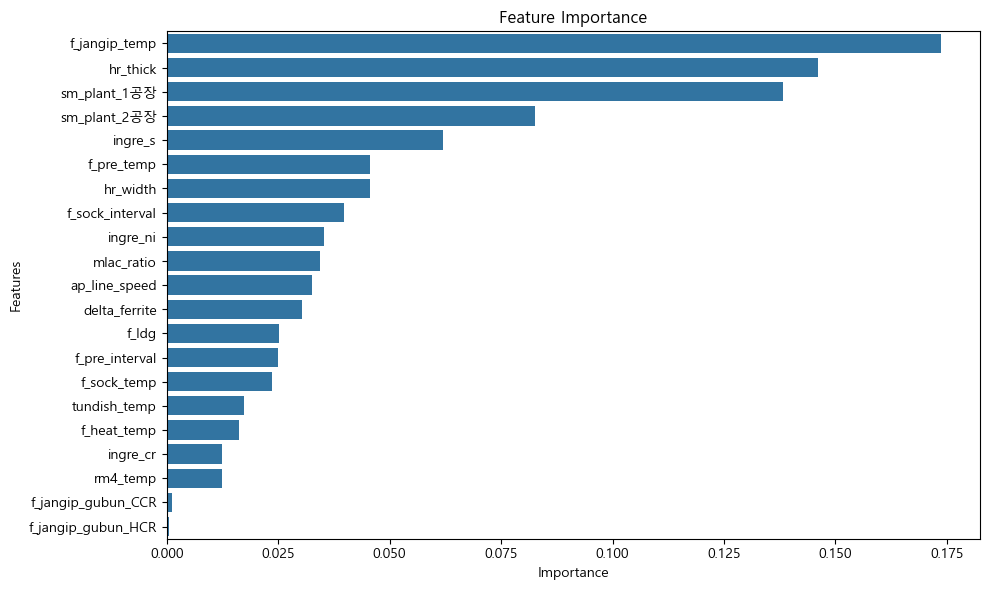

In [314]:
importance = pd.Series(clf.feature_importances_, index=X_train_res.columns)
importance = importance.sort_values(ascending=False)
# print(importance)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### - BorderlineSMOTE 샘플링 활용

In [223]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]
}

dtc = GradientBoostingClassifier(random_state=42)
grid_tree = RandomizedSearchCV(dtc, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1, cv=3)
grid_tree.fit(X_train_res2, y_train_res2)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'learning_rate': 0.05}
best score :  0.9874442526689587


In [236]:
clf = GradientBoostingClassifier(max_depth=10, 
                            min_samples_leaf=1, 
                            min_samples_split=10,
                            n_estimators=150,
                            learning_rate=0.05,
                            random_state=42)
clf.fit(X_train_res2, y_train_res2)

y_pred = clf.predict(X_test)

print("classification_report:\n", classification_report(y_test, y_pred))

classification_report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4600
           1       0.60      0.22      0.32       126

    accuracy                           0.98      4726
   macro avg       0.79      0.61      0.66      4726
weighted avg       0.97      0.98      0.97      4726



#### - ADASYN 샘플링 활용

In [246]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]
}

dtc = GradientBoostingClassifier(random_state=42)
grid_tree = RandomizedSearchCV(dtc, param_distributions=param_grid, refit=True, scoring='f1', n_jobs=-1, cv=3)
grid_tree.fit(X_train_res3, y_train_res3)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10, 'learning_rate': 0.1}
best score :  0.9810942044004012


In [259]:
clf = GradientBoostingClassifier(max_depth=10, 
                            min_samples_leaf=5, 
                            min_samples_split=10,
                            n_estimators=150,
                            learning_rate=0.1,
                            random_state=42)
clf.fit(X_train_res3, y_train_res3)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] 

threshold = 0.1
y_pred_thresh = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4600
           1       0.42      0.37      0.39       126

    accuracy                           0.97      4726
   macro avg       0.70      0.68      0.69      4726
weighted avg       0.97      0.97      0.97      4726



## SVM

#### - smoteTomek 샘플링 활용

In [260]:
v_feature_names = X_train_res.columns

scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(X_train_res)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)
X_test_scaled = scaler.transform(X_test)

In [261]:
param_grid = {
    'gamma': [0.1 * gamma for gamma in range(1, 11)],
    'C': [0.1 * c for c in range(1, 13)],
}

svc = SVC(random_state=42)
grid_tree = RandomizedSearchCV(svc, param_distributions=param_grid, refit=True, scoring='recall', n_jobs=-1, cv=3)
grid_tree.fit(df_x_scaled, y_train_res)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'gamma': 0.2, 'C': 1.2000000000000002}
best score :  0.9953244411560894


In [276]:
svc = SVC(C=1.2, gamma=0.2, random_state=42, class_weight='balanced')
svc.fit(df_x_scaled, y_train_res)

y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4600
           1       0.38      0.31      0.34       126

    accuracy                           0.97      4726
   macro avg       0.68      0.65      0.66      4726
weighted avg       0.97      0.97      0.97      4726



## NN

#### - smoteTomek 샘플링 활용

In [286]:
param_grid = {
    'activation': ["logistic", "tanh", "relu"],
    'solver': ["lbfgs", "sgd", "adam"],
    'batch_size': [20 * batch for batch in range(1, 10)],
}

nn = MLPClassifier(random_state=42, max_iter=1000)
grid_tree = RandomizedSearchCV(nn, param_distributions=param_grid, refit=True, scoring='recall', n_jobs=-1, cv=3)
grid_tree.fit(X_train_res, y_train_res)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

best parameters :  {'solver': 'sgd', 'batch_size': 80, 'activation': 'logistic'}
best score :  1.0


In [296]:
clf = MLPClassifier(activation='relu', solver='adam', batch_size=80)

clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

print("classification_report:\n", classification_report(y_test, y_pred))

classification_report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80      4600
           1       0.05      0.67      0.10       126

    accuracy                           0.67      4726
   macro avg       0.52      0.67      0.45      4726
weighted avg       0.96      0.67      0.78      4726



> NN은 1에 대한 precision이 너무 낮아 다른 오버샘플링 경우는 패스 

# 6. 모델링 성능비교

In [329]:
model_names = ["DecisionTree", "RandomForest", "GradientBoost", "NeuralNet"]
model_trainAccuracy = []
model_testAccuracy = []
model_precision = []
model_recall = []
model_f1score = []

# 모델별 평가
# 1. Decision Tree
clf = DecisionTreeClassifier(max_depth=19, min_samples_leaf=10, min_samples_split=10,
                             class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)
y_train_pred = clf.predict(X_train_res)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.4).astype(int)

model_trainAccuracy.append(accuracy_score(y_train_res, y_train_pred))
model_testAccuracy.append(accuracy_score(y_test, y_pred_thresh))
model_precision.append(precision_score(y_test, y_pred_thresh, zero_division=0))
model_recall.append(recall_score(y_test, y_pred_thresh))
model_f1score.append(f1_score(y_test, y_pred_thresh, zero_division=0))

# 2. Random Forest
clf = BalancedRandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=3,
                                     max_depth=30, class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)
y_train_pred = clf.predict(X_train_res)
y_pred = clf.predict(X_test)
y_pred_thresh = (y_proba >= 0.4).astype(int)
model_trainAccuracy.append(accuracy_score(y_train_res, y_train_pred))
model_testAccuracy.append(accuracy_score(y_test, y_pred_thresh))
model_precision.append(precision_score(y_test, y_pred_thresh, zero_division=0))
model_recall.append(recall_score(y_test, y_pred_thresh))
model_f1score.append(f1_score(y_test, y_pred_thresh, zero_division=0))

# 3. Gradient Boosting
clf = GradientBoostingClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=10,
                                 n_estimators=150, learning_rate=0.05, random_state=42)
clf.fit(X_train_res, y_train_res)
y_train_pred = clf.predict(X_train_res)
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)
model_trainAccuracy.append(accuracy_score(y_train_res, y_train_pred))
model_testAccuracy.append(accuracy_score(y_test, y_pred_thresh))
model_precision.append(precision_score(y_test, y_pred_thresh, zero_division=0))
model_recall.append(recall_score(y_test, y_pred_thresh))
model_f1score.append(f1_score(y_test, y_pred_thresh, zero_division=0))

# 4. Neural Net
clf = MLPClassifier(activation='relu', solver='adam', batch_size=80, random_state=42)
clf.fit(X_train_res, y_train_res)
y_train_pred = clf.predict(X_train_res)
y_pred = clf.predict(X_test)
model_trainAccuracy.append(accuracy_score(y_train_res, y_train_pred))
model_testAccuracy.append(accuracy_score(y_test, y_pred))
model_precision.append(precision_score(y_test, y_pred, zero_division=0))
model_recall.append(recall_score(y_test, y_pred))
model_f1score.append(f1_score(y_test, y_pred, zero_division=0))

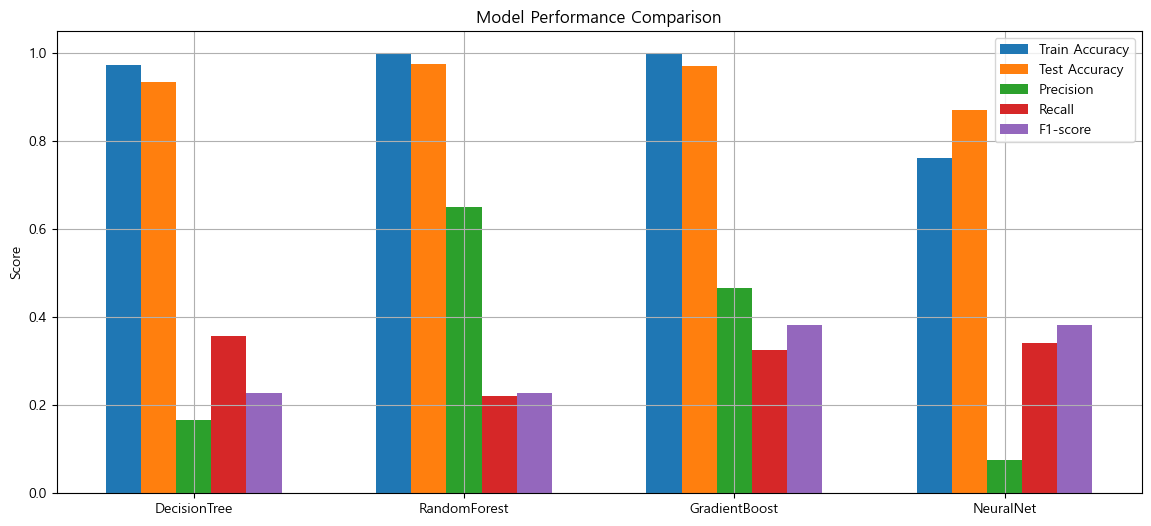

In [311]:
x = np.arange(len(model_names)) 
width = 0.13

plt.figure(figsize=(14,6))
plt.bar(x - width*2, model_trainAccuracy, width, label='Train Accuracy')
plt.bar(x - width, model_testAccuracy, width, label='Test Accuracy')
plt.bar(x, model_precision, width, label='Precision')
plt.bar(x + width, model_recall, width, label='Recall')
plt.bar(x + width*2, model_f1score, width, label='F1-score')

plt.xticks(x, model_names)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [328]:
# df.to_csv('a2_sts304.csv', encoding='euc-kr', index=False)